# AutoGluon 모델 기반 경제지표를 이용한 경기 흐름 예측

# [0] 데이터 분석 준비

### 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 코랩 환경 한글 글꼴 설치, 설치 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,678 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120882 files and dire

### 서드파티 모듈 설치

In [2]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.7/416.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

### 모듈 로드

In [3]:
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.rc('font', family='NanumBarunGothic')

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(22) # Seed 고정

### 데이터 로드

In [6]:
eco_df = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/data/경제지표데이터/finance_final_68.csv', encoding = 'utf-8')

In [7]:
eco_df

,날짜,선행종합지수(2020=100),재고순환지표(%p),경제심리지수,기계류내수출하지수(선박제외)(2020=100),건설수주액(실질)(십억원),수출입물가비율(2015=100),코스피(1980.1.4=100),장단기금리차(%p),동행종합지수(2020=100),...,뉴스심리지수,현재경기판단,현재생활형편,소비자심리지수(CCSI),up_down,미_금리,미국채_2,미국채_5,미국채_10,미국채_20
0,2003-01-01,53.7,-0.4,101.4,90.1,8145.7,148.2,604.9,0.99,57.8,...,106.39,82,87,97.0,1,1.24,1.743333,3.052381,4.048571,5.021905
1,2003-02-01,53.7,-0.9,100.1,88.8,8048.8,148.9,595.1,0.84,57.7,...,106.39,82,87,97.0,1,1.26,1.627895,2.897895,3.902632,4.870000
2,2003-03-01,53.8,-1.8,98.5,87.6,7904.5,149.7,591.1,0.72,57.7,...,106.39,82,87,97.0,1,1.25,1.573810,2.783810,3.807143,4.816190
3,2003-04-01,53.7,-6.2,97.5,86.3,7858.6,150.3,576.1,0.61,57.6,...,106.39,71,45,91.0,0,1.26,1.622381,2.928571,3.958571,4.911905
4,2003-05-01,53.7,-8.5,95.5,85.4,7624.8,151.2,583.4,0.53,57.8,...,106.39,71,45,91.0,1,1.26,1.415238,2.515714,3.569048,4.521429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-05-01,109.8,-17.2,93.2,99.9,10466.3,84.5,2488.4,-0.15,110.3,...,96.52,64,88,98.0,1,5.06,4.131818,3.591364,3.573636,3.963636
245,2023-06-01,110.5,-13.0,94.6,99.0,11826.5,86.0,2548.9,-0.16,110.3,...,101.64,69,89,100.7,1,5.08,4.639524,3.949524,3.748095,4.041905
246,2023-07-01,111.1,-9.6,94.7,99.3,12177.8,86.6,2572.6,-0.04,110.0,...,102.08,75,91,103.2,1,5.12,4.828500,4.141500,3.899500,4.149500
247,2023-08-01,111.4,-7.9,94.6,98.4,9882.9,86.8,2585.1,0.12,110.0,...,99.03,72,91,103.1,1,5.33,4.901739,4.306522,4.167826,4.456522


### NA 처리

In [8]:
eco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   날짜                          249 non-null    object 
 1   선행종합지수(2020=100)            249 non-null    float64
 2   재고순환지표(%p)                  249 non-null    float64
 3   경제심리지수                      249 non-null    float64
 4   기계류내수출하지수(선박제외)(2020=100)   249 non-null    float64
 5   건설수주액(실질)(십억원)              249 non-null    float64
 6   수출입물가비율(2015=100)           249 non-null    float64
 7   코스피(1980.1.4=100)           249 non-null    float64
 8   장단기금리차(%p)                  249 non-null    float64
 9   동행종합지수(2020=100)            249 non-null    float64
 10  광공업생산지수(2020=100)           249 non-null    float64
 11  서비스업생산지수(도소매업제외)(2020=100)  249 non-null    float64
 12  건설기성액(실질)(십억원)              249 non-null    float64
 13  소매판매액지수(2020=100)           249 non

In [9]:
# fillna
#eco_df = eco_df.fillna(method = 'bfill').fillna(method = 'ffill')

### 수치형 변수만 사용

In [10]:
eco_num_df = eco_df.select_dtypes(include=['number'])
eco_num_df.head(2)

,선행종합지수(2020=100),재고순환지표(%p),경제심리지수,기계류내수출하지수(선박제외)(2020=100),건설수주액(실질)(십억원),수출입물가비율(2015=100),코스피(1980.1.4=100),장단기금리차(%p),동행종합지수(2020=100),광공업생산지수(2020=100),...,뉴스심리지수,현재경기판단,현재생활형편,소비자심리지수(CCSI),up_down,미_금리,미국채_2,미국채_5,미국채_10,미국채_20
0,53.7,-0.4,101.4,90.1,8145.7,148.2,604.9,0.99,57.8,51.6,...,106.39,82,87,97.0,1,1.24,1.743333,3.052381,4.048571,5.021905
1,53.7,-0.9,100.1,88.8,8048.8,148.9,595.1,0.84,57.7,51.7,...,106.39,82,87,97.0,1,1.26,1.627895,2.897895,3.902632,4.870000


# [1] Random Forest Regressor를 이용한 피쳐 중요도 파악
- 종속변수 : 기준금리
- 독립변수 : 기준금리 외 다른 변수

### 학습 준비

- target, X 분리

In [11]:
target = eco_num_df['기준금리']
eco_df_for_lr = eco_num_df.drop(['기준금리'], axis = 1)

- Scaling

    - % 단위의 칼럼 + 기타 : MinMaxScaler
    - 일반 수치형, 100기준 칼럼 : StandardScaler

- % 단위 칼럼 : ['소비자물가지수변화율(서비스)', '실업률총계', '실_15-19세', '실_20-29세', '실_30-39세', '실_40-49세', '실_50-59세', '실_60세이상', '미_실업률', '미_mom', '미_yoy', ' '미_coremom', '미_coreyoy', '콜금리', '미_금리', '미국채_2', '미국채_5', '미국채_10', '미국채_20' 재고순환지표(%p), 장단기금리차(%p), CP유통수익률(%p), GDP 성장률 (%)]
<br/>

- 100기준 칼럼 : [ '경제심리지수', '소비자물가지수', '농산물및석유류제외지수', '식료품 및 에너지제외 지수', 'BSI_전산업', 'BSI_제조업', 'BSI_비제조업', '소비자심리지수(CCSI)', '현재경기판단','현재생활형편', '뉴스심리지수', '원달러환율', '동행지수순환변동치', '선행지수순환변동치','달러인덱스'
,'선행종합지수(2020=100)','기계류내수출하지수(선박제외)(2020=100)','수출입물가비율(2015=100)', '코스피(1980.1.4=100)', '동행종합지수(2020=100)', '광공업생산지수(2020=100)'
,'서비스업생산지수(도소매업제외)(2020=100)', '소매판매액지수(2020=100)', '내수출하지수(2020=100)', '후행종합지수(2020=100)', '생산자제품재고지수(2020=100)']
<br/>

- 금액/인원 단위 칼럼 : ['건설수주액(실질)(십억원)', '건설기성액(실질)(십억원)','수입액(실질)(백만불)', '소비재수입액(실질)(백만불)', '국내총생산(GDP)(당해년 가격) (10억원\)', '1인당 GDP(당해년 가격) (만원)', '비농림어업취업자수(천명)','취업자수(천명)']

<br/>
- 기타 : ['미_cpi','미_corecpi', 'South Korea', 'United States of America']

In [12]:
std_cols =   [ '경제심리지수', '소비자물가지수', '농산물및석유류제외지수', '식료품 및 에너지제외 지수', 'BSI_전산업', 'BSI_제조업', 'BSI_비제조업', '소비자심리지수(CCSI)', '현재경기판단','현재생활형편', '뉴스심리지수', '원달러환율', '동행지수순환변동치', '선행지수순환변동치','달러인덱스' ,'선행종합지수(2020=100)','기계류내수출하지수(선박제외)(2020=100)','수출입물가비율(2015=100)', '코스피(1980.1.4=100)', '동행종합지수(2020=100)', '광공업생산지수(2020=100)' ,'서비스업생산지수(도소매업제외)(2020=100)', '소매판매액지수(2020=100)', '내수출하지수(2020=100)', '후행종합지수(2020=100)', '생산자제품재고지수(2020=100)']
std_scaler = StandardScaler()
eco_df_for_lr[std_cols] = std_scaler.fit_transform(eco_df_for_lr[std_cols])

In [13]:
minmax_cols = ['소비자물가지수변화율(서비스)', '실업률총계', '실_15-19세', '실_20-29세', '실_30-39세', '실_40-49세', '실_50-59세', '실_60세이상', '미_실업률', '미_mom', '미_yoy',  '미_coremom', '미_coreyoy', '콜금리', '미_금리', '미국채_2', '미국채_5', '미국채_10', '미국채_20', '재고순환지표(%p)', '장단기금리차(%p)', 'CP유통수익률(%p)', 'GDP 성장률 (%)', '건설수주액(실질)(십억원)', '건설기성액(실질)(십억원)','수입액(실질)(백만불)', '소비재수입액(실질)(백만불)', '국내총생산(GDP)(당해년 가격) (10억원\)', '1인당 GDP(당해년 가격) (만원)', '비농림어업취업자수(천명)','취업자수(천명)','미_cpi','미_corecpi', 'South Korea', 'United States of America']
minmax_scaler = MinMaxScaler()
eco_df_for_lr[minmax_cols] = minmax_scaler.fit_transform(eco_df_for_lr[minmax_cols])

### 모델 학습

In [14]:
rf = RandomForestRegressor()

rf.fit(eco_df_for_lr, target)

RandomForestRegressor()

### 피쳐중요도 확인

In [15]:
# 피쳐 중요도 확인
feature_importances = rf.feature_importances_

# 피쳐 중요도를 기준으로 내림차순 정렬
indices = np.argsort(feature_importances)[::-1]

# 각 피쳐의 중요도 출력
for f in range(eco_df_for_lr.shape[1]):
    print(f"{eco_df_for_lr.columns[indices[f]]}: {feature_importances[indices[f]]}")

콜금리: 0.9570837759522903
CP유통수익률(%p): 0.013259843928079244
미국채_2: 0.011040390852986625
미국채_5: 0.004102872783496666
내수출하지수(2020=100): 0.00376899999766967
달러인덱스: 0.003666111425313504
건설수주액(실질)(십억원): 0.0009262775261627649
코스피(1980.1.4=100): 0.000865096412289064
미_금리: 0.0003727393251166841
미국채_20: 0.0003327042661509645
서비스업생산지수(도소매업제외)(2020=100): 0.00024541174969811876
실_15-19세: 0.00024199184848303925
소비자물가지수: 0.00023649365635832533
미_corecpi: 0.00022188400600159136
후행종합지수(2020=100): 0.00020911295602987006
농산물및석유류제외지수: 0.00018641604731584518
취업자수(천명): 0.00018542737641455274
비농림어업취업자수(천명): 0.00018381940888967304
국내총생산(GDP)(당해년 가격) (10억원\): 0.00017833191445175311
동행종합지수(2020=100): 0.0001757806426435794
미_cpi: 0.00016105913819483577
미_실업률: 0.0001491121260153764
광공업생산지수(2020=100): 0.00014735740115304945
선행종합지수(2020=100): 0.00013086077342032914
뉴스심리지수: 0.0001231556912264658
생산자제품재고지수(2020=100): 0.00012257918562033046
건설기성액(실질)(십억원): 0.00012114009116654368
기계류내수출하지수(선박제외)(2020=100): 0.00011820565

### 피쳐 Selection

- 랜덤포래스트 학습 결과 상위 5개 피쳐
- EDA를 바탕으로 높은 연관성을 보이는 피쳐 직접 추가

In [16]:
top_20_features = eco_df_for_lr.columns[indices[:5]].tolist() #+ ['경제심리지수','소비자물가지수변화율(서비스)', '뉴스심리지수','현재경기판단']

top_20_features

['콜금리', 'CP유통수익률(%p)', '미국채_2', '미국채_5', '내수출하지수(2020=100)']

# [2] 시계열 분석

- 회귀분석 피쳐중요도 바탕으로 시계열 예측

### 전처리

In [17]:
eco_df_for_ts = eco_df_for_lr[top_20_features]

In [18]:
eco_df_for_ts

,콜금리,CP유통수익률(%p),미국채_2,미국채_5,내수출하지수(2020=100)
0,0.803383,0.590164,0.325188,0.580284,-1.743769
1,0.807611,0.606557,0.302130,0.548103,-1.823966
2,0.794926,0.622951,0.291327,0.524339,-1.884114
3,0.794926,0.655738,0.301029,0.554493,-1.974336
4,0.758985,0.672131,0.259655,0.468492,-2.014435
...,...,...,...,...,...
244,0.653277,0.491803,0.802259,0.692558,0.501757
245,0.652431,0.491803,0.903667,0.767165,0.511781
246,0.640592,0.491803,0.941413,0.807155,0.531831
247,0.646512,0.491803,0.956042,0.841530,0.501757


- AutoGluon 타임시리즈 예측을 위한 처리
    - 날짜를 나타내는 'timestamp' 칼럼과 각 값을 구분하는 'item' 칼럼이 반드시 필요
    - item은 여기서 0으로 통일해도 무방하다.

In [19]:
eco_df_for_ts['timestamp'] = pd.to_datetime(eco_df['날짜'])
eco_df_for_ts['item_id'] = 0
eco_df_for_ts['기준금리'] = target

<ipython-input-19-62d32f1e6880>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_df_for_ts['timestamp'] = pd.to_datetime(eco_df['날짜'])
<ipython-input-19-62d32f1e6880>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_df_for_ts['item_id'] = 0
<ipython-input-19-62d32f1e6880>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [20]:
eco_df_for_ts

,콜금리,CP유통수익률(%p),미국채_2,미국채_5,내수출하지수(2020=100),timestamp,item_id,기준금리
0,0.803383,0.590164,0.325188,0.580284,-1.743769,2003-01-01,0,4.25
1,0.807611,0.606557,0.302130,0.548103,-1.823966,2003-02-01,0,4.25
2,0.794926,0.622951,0.291327,0.524339,-1.884114,2003-03-01,0,4.25
3,0.794926,0.655738,0.301029,0.554493,-1.974336,2003-04-01,0,4.25
4,0.758985,0.672131,0.259655,0.468492,-2.014435,2003-05-01,0,4.00
...,...,...,...,...,...,...,...,...
244,0.653277,0.491803,0.802259,0.692558,0.501757,2023-05-01,0,3.50
245,0.652431,0.491803,0.903667,0.767165,0.511781,2023-06-01,0,3.50
246,0.640592,0.491803,0.941413,0.807155,0.531831,2023-07-01,0,3.50
247,0.646512,0.491803,0.956042,0.841530,0.501757,2023-08-01,0,3.50


### 3개월 단위 예측

#### - Validation : [MSE : 0.0001]

- train test split

In [21]:
train = eco_df_for_ts.iloc[: 246, :]
test = eco_df_for_ts.iloc[246 :, :]

train.shape, test.shape

((246, 8), (3, 8))

In [22]:
data = TimeSeriesDataFrame(train)
data

콜금리  CP유통수익률(%p)     미국채_2     미국채_5  \
item_id timestamp                                               
0       2003-01-01  0.803383     0.590164  0.325188  0.580284   
        2003-02-01  0.807611     0.606557  0.302130  0.548103   
        2003-03-01  0.794926     0.622951  0.291327  0.524339   
        2003-04-01  0.794926     0.655738  0.301029  0.554493   
        2003-05-01  0.758985     0.672131  0.259655  0.468492   
...                      ...          ...       ...       ...   
        2023-02-01  0.622622     0.639344  0.882527  0.765620   
        2023-03-01  0.622622     0.557377  0.836373  0.740909   
        2023-04-01  0.631501     0.508197  0.779126  0.681233   
        2023-05-01  0.653277     0.491803  0.802259  0.692558   
        2023-06-01  0.652431     0.491803  0.903667  0.767165   

                    내수출하지수(2020=100)  기준금리  
item_id timestamp                           
0       2003-01-01         -1.743769  4.25  
        2003-02-01         -1.823966  4.25  
        2003-03-01         -1.884114  4.25  
        2003-04-01         -1.974336  4.25  
        2003-05-01         -2.014435  4.00  
...                              ...   ...  
        2023-02-01          0.501757  3.50  
        2023-03-01          0.541855  3.50  
        2023-04-01          0.471683  3.50  
        2023-05-01          0.501757  3.50  
        2023-06-01          0.511781  3.50  

[246 rows x 6 columns]

- AutoGluon 자동화 시계열 예측 모델 학습

In [23]:
predictor = TimeSeriesPredictor(
    prediction_length = 3,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070304'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       11.29 GB / 12.68 GB (89.1%)
Disk Space Avail:   191.69 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 246 rows, 1 time series. Median time series length is 246 (min=246, max=246). 

Provided dat

- 전체 데이터를 대상으로 다시 학습

In [24]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- valid 예측

In [25]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [26]:
# 원래값
test['기준금리']

246    3.5
247    3.5
248    3.5
Name: 기준금리, dtype: float64

In [27]:
# 예측값
pred.reset_index()['mean']

0    3.504825
1    3.507521
2    3.505229
Name: mean, dtype: float64

In [28]:
valid_3 = pred.reset_index()['mean']

In [29]:
round(mean_squared_error(test['기준금리'], pred.reset_index()['mean']), 4)

0.0

In [30]:
eco_df_for_ts

,콜금리,CP유통수익률(%p),미국채_2,미국채_5,내수출하지수(2020=100),timestamp,item_id,기준금리
0,0.803383,0.590164,0.325188,0.580284,-1.743769,2003-01-01,0,4.25
1,0.807611,0.606557,0.302130,0.548103,-1.823966,2003-02-01,0,4.25
2,0.794926,0.622951,0.291327,0.524339,-1.884114,2003-03-01,0,4.25
3,0.794926,0.655738,0.301029,0.554493,-1.974336,2003-04-01,0,4.25
4,0.758985,0.672131,0.259655,0.468492,-2.014435,2003-05-01,0,4.00
...,...,...,...,...,...,...,...,...
244,0.653277,0.491803,0.802259,0.692558,0.501757,2023-05-01,0,3.50
245,0.652431,0.491803,0.903667,0.767165,0.511781,2023-06-01,0,3.50
246,0.640592,0.491803,0.941413,0.807155,0.531831,2023-07-01,0,3.50
247,0.646512,0.491803,0.956042,0.841530,0.501757,2023-08-01,0,3.50


In [31]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[246:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[246: , :]

<ipython-input-32-5f2e605e88a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/cor

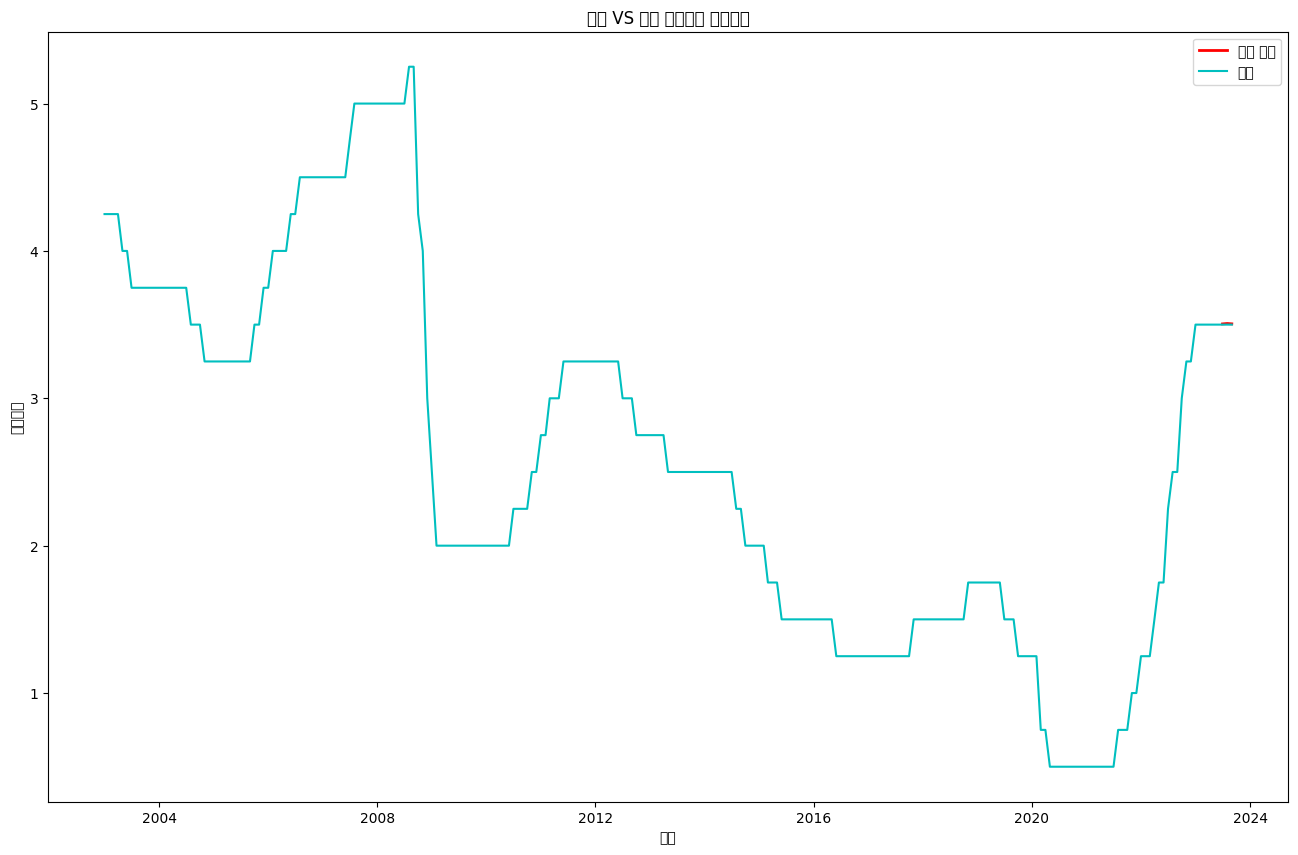

In [32]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### - Prediction

In [33]:
predictor = TimeSeriesPredictor(
    prediction_length = 3,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070512'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.93 GB / 12.68 GB (86.2%)
Disk Space Avail:   191.68 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 3,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided dat

In [34]:
pred_3 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: AutoETS


In [35]:
for_plot_3 = pred_3.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [36]:
for_plot_3

,날짜,mean
0,2023-10-01,3.5
1,2023-11-01,3.5
2,2023-12-01,3.5


<ipython-input-37-2f1fce5b0813>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/cor

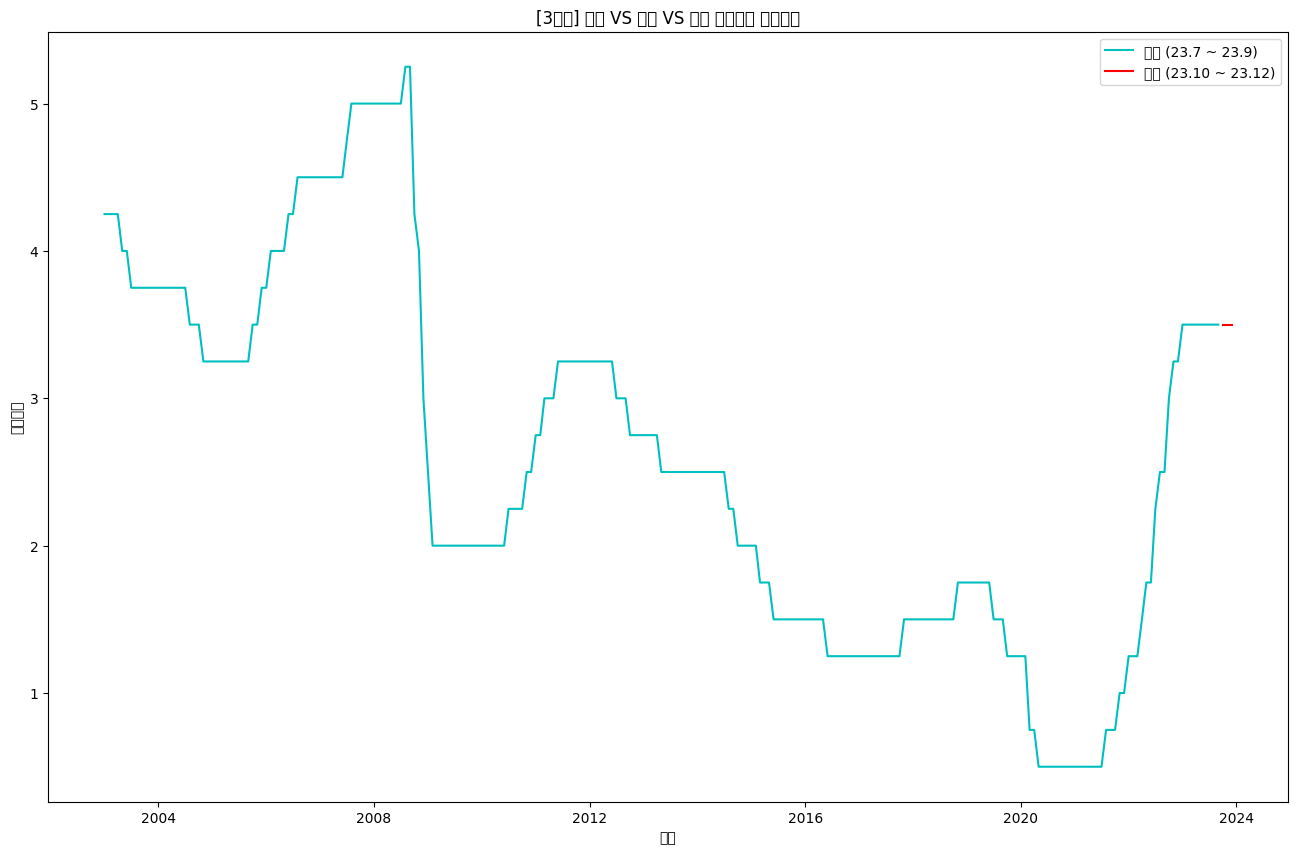

In [37]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_3['날짜'], for_plot_3['mean'], label='예측 (23.10 ~ 23.12)', c = 'r')

plt.title('[3개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 3개월 검증결과 큰 차이가 없음 (실제로 3.5 현행 유지중)
- 향후 3개월간 유지 예측 (10월 ~ 12월)

### 6개월 단위 예측 [MSE : 0.3936]

#### Validation

- train test split

In [38]:
train = eco_df_for_ts.iloc[: 243, :]
test = eco_df_for_ts.iloc[243 :, :]

train.shape, test.shape

((243, 8), (6, 8))

In [39]:
data = TimeSeriesDataFrame(train)
data

콜금리  CP유통수익률(%p)     미국채_2     미국채_5  \
item_id timestamp                                               
0       2003-01-01  0.803383     0.590164  0.325188  0.580284   
        2003-02-01  0.807611     0.606557  0.302130  0.548103   
        2003-03-01  0.794926     0.622951  0.291327  0.524339   
        2003-04-01  0.794926     0.655738  0.301029  0.554493   
        2003-05-01  0.758985     0.672131  0.259655  0.468492   
...                      ...          ...       ...       ...   
        2022-11-01  0.553066     0.524590  0.876498  0.789241   
        2022-12-01  0.582452     0.639344  0.833569  0.728579   
        2023-01-01  0.589641     0.688525  0.817376  0.703314   
        2023-02-01  0.622622     0.639344  0.882527  0.765620   
        2023-03-01  0.622622     0.557377  0.836373  0.740909   

                    내수출하지수(2020=100)  기준금리  
item_id timestamp                           
0       2003-01-01         -1.743769  4.25  
        2003-02-01         -1.823966  4.25  
        2003-03-01         -1.884114  4.25  
        2003-04-01         -1.974336  4.25  
        2003-05-01         -2.014435  4.00  
...                              ...   ...  
        2022-11-01          0.622053  3.25  
        2022-12-01          0.521806  3.25  
        2023-01-01          0.501757  3.50  
        2023-02-01          0.501757  3.50  
        2023-03-01          0.541855  3.50  

[243 rows x 6 columns]

- AutoGluon 자동화 시계열 예측 모델 학습

In [40]:
predictor = TimeSeriesPredictor(
    prediction_length = 6,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070523'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.96 GB / 12.68 GB (86.5%)
Disk Space Avail:   191.68 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 243 rows, 1 time series. Median time series length is 243 (min=243, max=243). 

Provided dat

- 전체 데이터를 대상으로 다시 학습

In [41]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- test 예측

In [42]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [43]:
# 원래값
test['기준금리']

243    3.5
244    3.5
245    3.5
246    3.5
247    3.5
248    3.5
Name: 기준금리, dtype: float64

In [44]:
# 예측값
valid_6 = pred.reset_index()['mean']
pred.reset_index()['mean']

0    2.719051
1    2.696412
2    2.680012
3    3.031157
4    3.167980
5    3.178628
Name: mean, dtype: float64

In [45]:
round(mean_squared_error(test['기준금리'], pred.reset_index()['mean']), 4)

0.3936

In [46]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[243:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[243: , :]

<ipython-input-47-ce23139bd83f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/cor

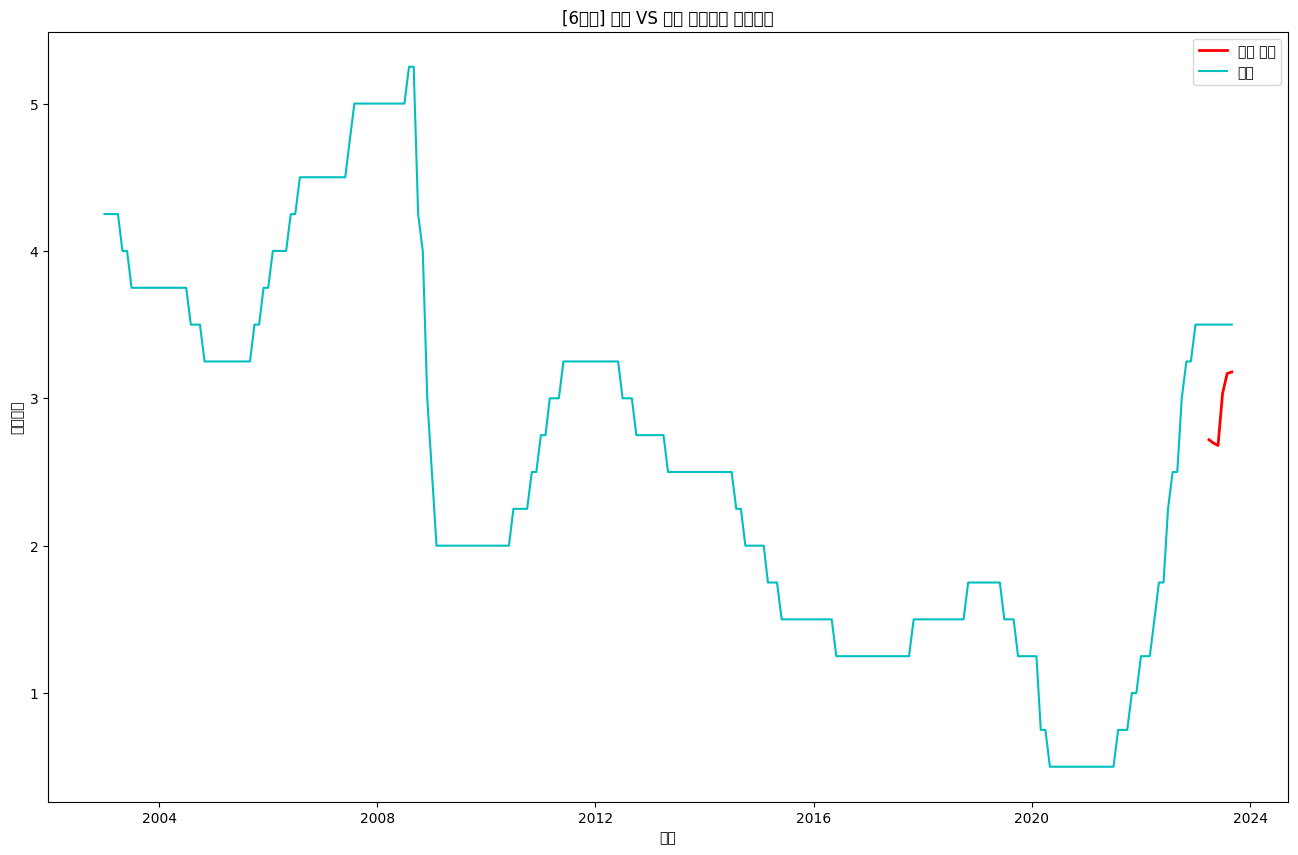

In [47]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[6개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### - Prediction

In [48]:
predictor = TimeSeriesPredictor(
    prediction_length = 6,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070536'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.96 GB / 12.68 GB (86.4%)
Disk Space Avail:   191.67 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided dat

In [49]:
pred_6 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [50]:
for_plot_6 = pred_6.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [51]:
for_plot_6

,날짜,mean
0,2023-10-01,3.512280
1,2023-11-01,3.513914
2,2023-12-01,3.511042
3,2024-01-01,3.515321
4,2024-02-01,3.517859
5,2024-03-01,3.517821


<ipython-input-52-caf64ee4b889>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/cor

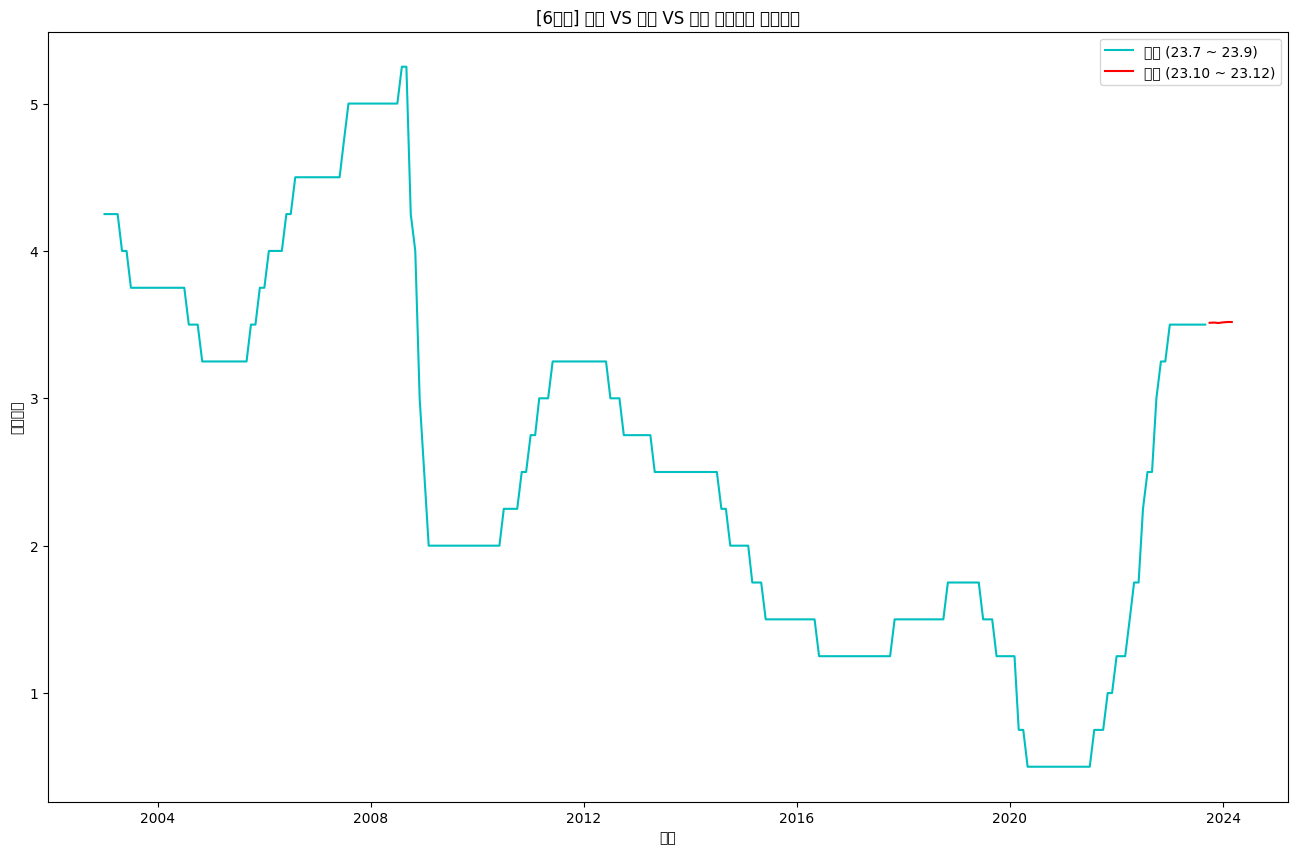

In [52]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_6['날짜'] = pd.to_datetime(for_plot_6['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_6['날짜'], for_plot_6['mean'], label='예측 (23.10 ~ 23.12)', c = 'r')

plt.title('[6개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 6개월 검증결과 큰 차이가 없음
- 향후 6개월간 유지 예측 (10월 ~ 03월)

### 12개월 단위 예측 [MSE : 0.6921]

#### Validation

- train test split

In [53]:
train = eco_df_for_ts.iloc[: 237, :]
test = eco_df_for_ts.iloc[237 :, :]

train.shape, test.shape

((237, 8), (12, 8))

In [54]:
data = TimeSeriesDataFrame(train)
data

콜금리  CP유통수익률(%p)     미국채_2     미국채_5  \
item_id timestamp                                               
0       2003-01-01  0.803383     0.590164  0.325188  0.580284   
        2003-02-01  0.807611     0.606557  0.302130  0.548103   
        2003-03-01  0.794926     0.622951  0.291327  0.524339   
        2003-04-01  0.794926     0.655738  0.301029  0.554493   
        2003-05-01  0.758985     0.672131  0.259655  0.468492   
...                      ...          ...       ...       ...   
        2022-05-01  0.216702     0.131148  0.499626  0.543185   
        2022-06-01  0.267442     0.163934  0.575812  0.608951   
        2022-07-01  0.315222     0.213115  0.583383  0.561769   
        2022-08-01  0.376956     0.262295  0.626127  0.575078   
        2022-09-01  0.434038     0.311475  0.747301  0.714493   

                    내수출하지수(2020=100)  기준금리  
item_id timestamp                           
0       2003-01-01         -1.743769  4.25  
        2003-02-01         -1.823966  4.25  
        2003-03-01         -1.884114  4.25  
        2003-04-01         -1.974336  4.25  
        2003-05-01         -2.014435  4.00  
...                              ...   ...  
        2022-05-01          0.762398  1.75  
        2022-06-01          0.722300  1.75  
        2022-07-01          0.792472  2.25  
        2022-08-01          0.872670  2.50  
        2022-09-01          0.822546  2.50  

[237 rows x 6 columns]

- AutoGluon 자동화 시계열 예측 모델 학습

In [55]:
predictor = TimeSeriesPredictor(
    prediction_length = 12,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070559'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.71 GB / 12.68 GB (84.5%)
Disk Space Avail:   191.67 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 237 rows, 1 time series. Median time series length is 237 (min=237, max=237). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [56]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- test 예측

In [57]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [58]:
# 원래값
test['기준금리']

237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [59]:
# 예측값
valid_12 = pred.reset_index()['mean']

pred.reset_index()['mean']

0     1.994968
1     2.182750
2     2.213056
3     2.490178
4     2.481740
5     2.482936
6     2.627061
7     2.788452
8     2.737974
9     3.171212
10    3.394793
11    3.353462
Name: mean, dtype: float64

In [60]:
round(mean_squared_error(test['기준금리'], pred.reset_index()['mean']), 4)

0.6921

In [61]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[237:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[237: , :]

<ipython-input-62-5f2e605e88a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/cor

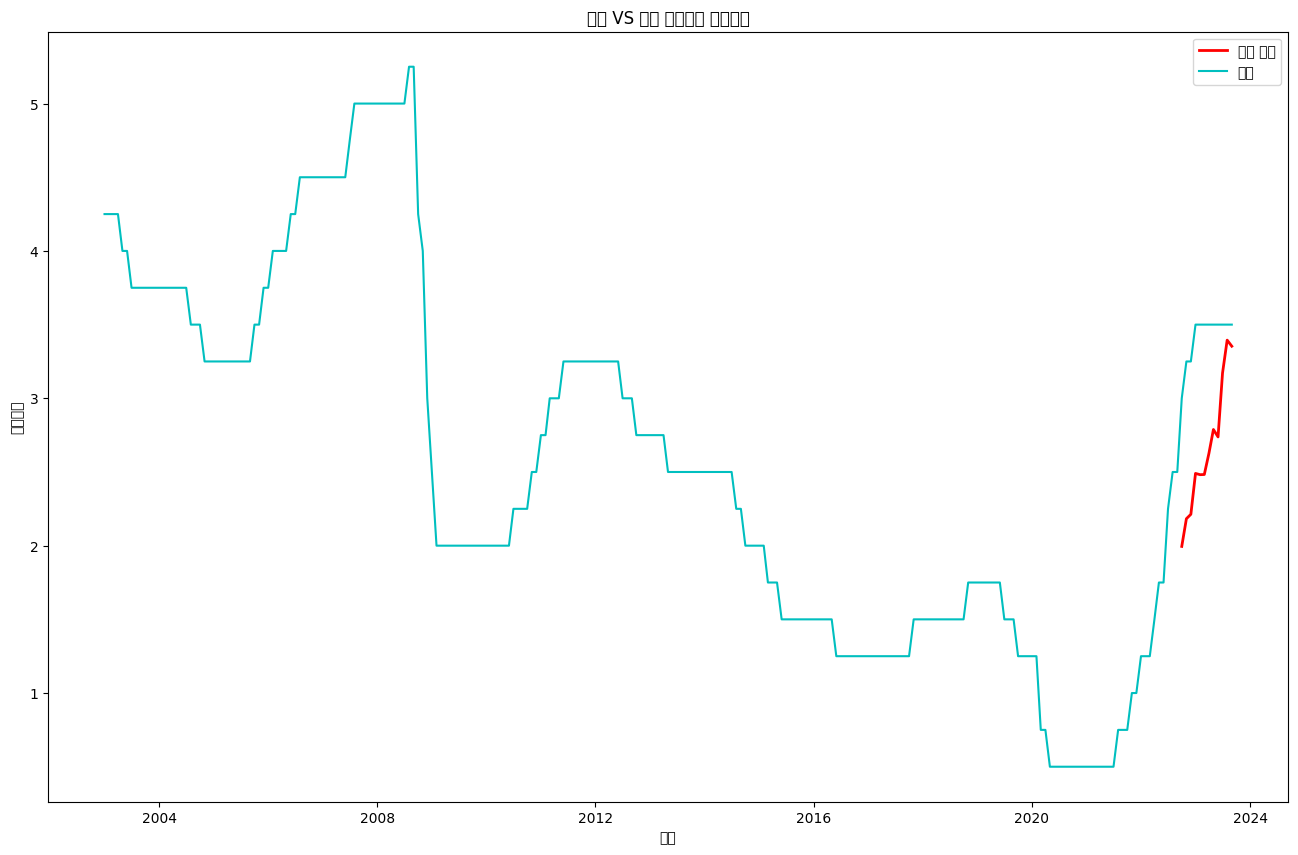

In [62]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [63]:
predictor = TimeSeriesPredictor(
    prediction_length = 12,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070615'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.65 GB / 12.68 GB (84.0%)
Disk Space Avail:   191.66 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [64]:
pred_12 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [65]:
for_plot_12 = pred_12.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

In [66]:
for_plot_12

,날짜,mean
0,2023-10-01,3.734116
1,2023-11-01,3.685753
2,2023-12-01,3.509016
3,2024-01-01,3.623616
4,2024-02-01,3.645766
5,2024-03-01,3.590398
6,2024-04-01,3.502121
7,2024-05-01,3.217683
8,2024-06-01,2.433310
9,2024-07-01,1.451704


<ipython-input-67-866e638018fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/cor

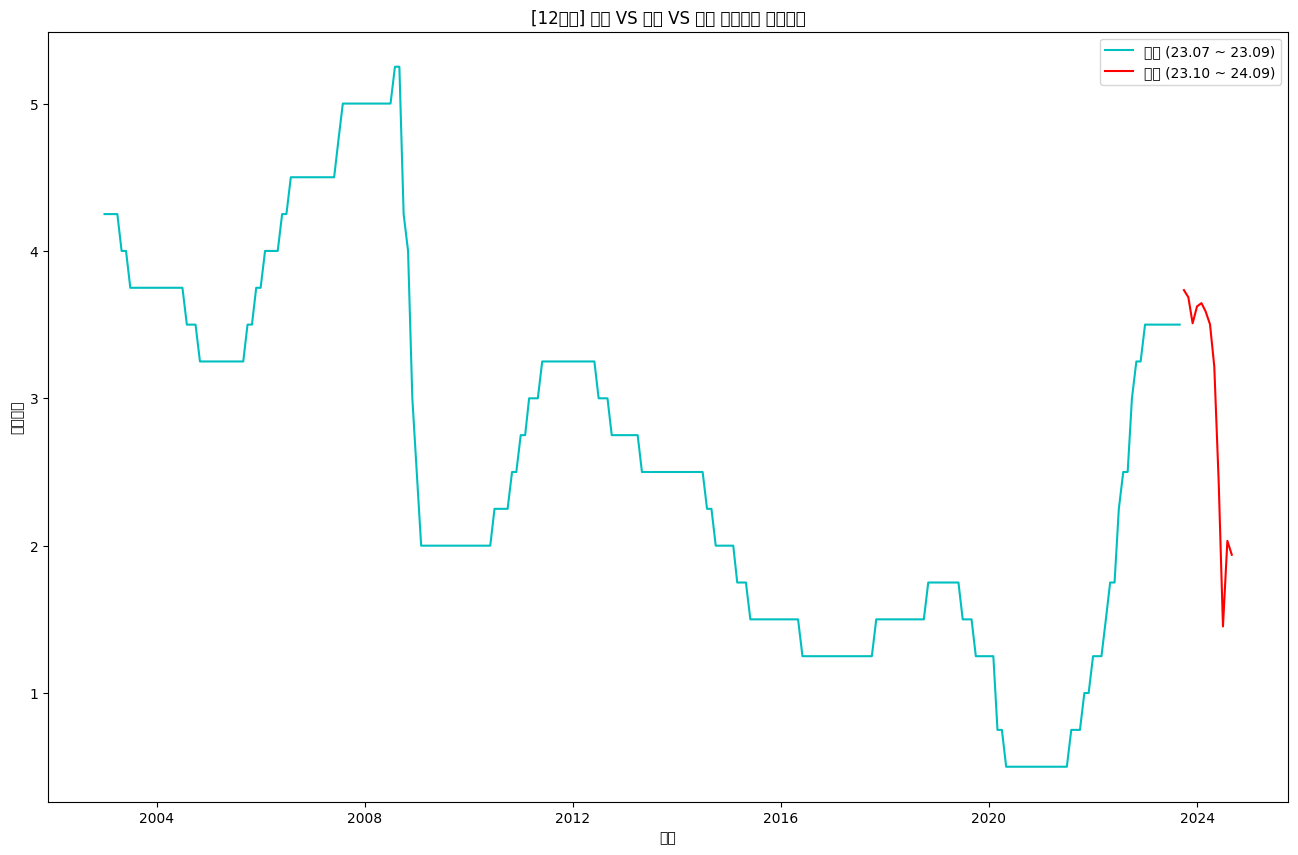

In [67]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_12['날짜'] = pd.to_datetime(for_plot_12['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.07 ~ 23.09)', c = 'c')
plt.plot(for_plot_12['날짜'], for_plot_12['mean'], label='예측 (23.10 ~ 24.09)', c = 'r')

plt.title('[12개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 12개 결과

### 18개월 단위 예측

- train test split

In [68]:
train = eco_df_for_ts.iloc[: 231, :]
test = eco_df_for_ts.iloc[231 :, :]

train.shape, test.shape

((231, 8), (18, 8))

In [69]:
data = TimeSeriesDataFrame(train)
data

콜금리  CP유통수익률(%p)     미국채_2     미국채_5  \
item_id timestamp                                               
0       2003-01-01  0.803383     0.590164  0.325188  0.580284   
        2003-02-01  0.807611     0.606557  0.302130  0.548103   
        2003-03-01  0.794926     0.622951  0.291327  0.524339   
        2003-04-01  0.794926     0.655738  0.301029  0.554493   
        2003-05-01  0.758985     0.672131  0.259655  0.468492   
...                      ...          ...       ...       ...   
        2021-11-01  0.066808     0.032787  0.078445  0.194941   
        2021-12-01  0.112474     0.065574  0.112799  0.200574   
        2022-01-01  0.149683     0.081967  0.172821  0.264932   
        2022-02-01  0.156237     0.098361  0.263654  0.321816   
        2022-03-01  0.161522     0.098361  0.358391  0.383798   

                    내수출하지수(2020=100)  기준금리  
item_id timestamp                           
0       2003-01-01         -1.743769  4.25  
        2003-02-01         -1.823966  4.25  
        2003-03-01         -1.884114  4.25  
        2003-04-01         -1.974336  4.25  
        2003-05-01         -2.014435  4.00  
...                              ...   ...  
        2021-11-01          0.782448  1.00  
        2021-12-01          0.932818  1.00  
        2022-01-01          1.023040  1.25  
        2022-02-01          1.033064  1.25  
        2022-03-01          0.982941  1.25  

[231 rows x 6 columns]

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [70]:
predictor = TimeSeriesPredictor(
    prediction_length = 18,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")
#predictor.fit( data, random_seed=42, presets="best_quality", excluded_model_types=["Naive", "SeasonalNaive","PatchTST", 'DirectTabular'])

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070643'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.62 GB / 12.68 GB (83.7%)
Disk Space Avail:   191.65 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 18,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 231 rows, 1 time series. Median time series length is 231 (min=231, max=231). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [71]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [72]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [73]:
# 원래값
test['기준금리']

231    1.50
232    1.75
233    1.75
234    2.25
235    2.50
236    2.50
237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [76]:
# 예측값
valid_18 = pred.reset_index()['mean']

pred.reset_index()['0.9']

0     1.513310
1     1.552253
2     1.572073
3     1.593476
4     1.697638
5     1.718017
6     1.733258
7     1.836758
8     1.856660
9     1.956905
10    1.971980
11    1.972483
12    2.019816
13    2.032038
14    2.027033
15    2.041240
16    2.139245
17    2.152318
Name: 0.9, dtype: float64

In [77]:
round(mean_squared_error(test['기준금리'],pred.reset_index()['0.7']), 4)

2.2216

In [78]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[231:, 1] = pred.reset_index()['mean']
for_plot_pred = for_plot_pred.iloc[231: , :]

<ipython-input-79-cb6f687c7cb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/cor

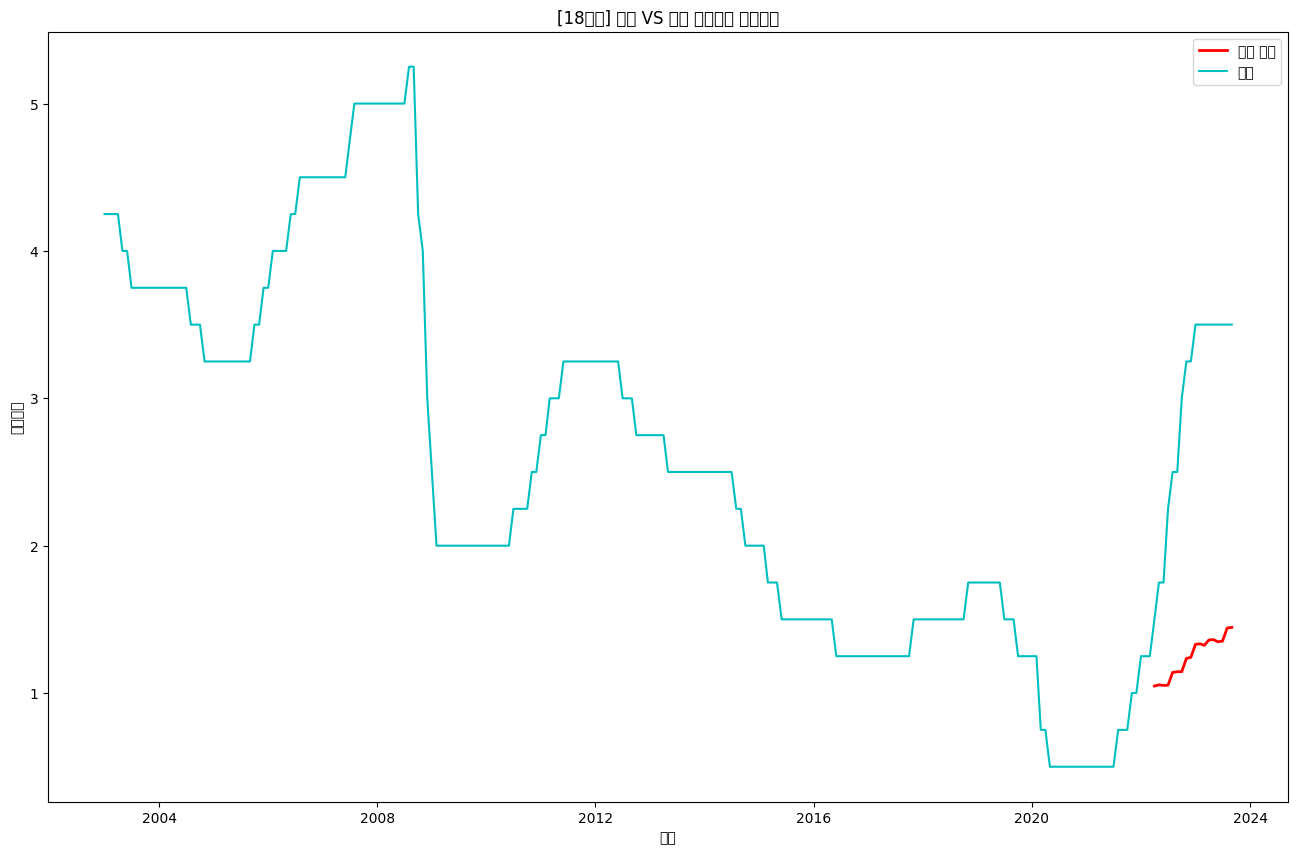

In [79]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[18개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [80]:
predictor = TimeSeriesPredictor(
    prediction_length = 18,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")
#predictor.fit( eco_df_for_ts, random_seed=42, presets="high_quality", excluded_model_types=["Naive", "SeasonalNaive","PatchTST", 'DirectTabular'])

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070745'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.59 GB / 12.68 GB (83.5%)
Disk Space Avail:   191.65 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 18,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [81]:
pred_18 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [82]:
pred_18

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  4.097823  3.636395  3.780523  3.865768  3.902502   
        2023-11-01  4.205670  3.750048  3.876619  3.979671  4.031621   
        2023-12-01  4.022326  3.515726  3.661247  3.777963  3.841589   
        2024-01-01  4.015426  3.466936  3.586178  3.714414  3.830136   
        2024-02-01  4.015631  3.415577  3.548895  3.687279  3.853927   
        2024-03-01  3.918256  3.209727  3.440275  3.587835  3.720069   
        2024-04-01  3.699867  3.025279  3.225276  3.339019  3.478463   
        2024-05-01  3.298382  2.506714  2.802109  2.965960  3.112113   
        2024-06-01  3.156166  2.424277  2.645394  2.816621  2.969078   
        2024-07-01  2.867308  2.133853  2.322392  2.500596  2.701267   
        2024-08-01  3.212050  2.352492  2.676994  2.819580  3.025921   
        2024-09-01  3.014226  2.153138  2.444180  2.635359  2.762611   
        2024-10-01  3.675972  2.788628  3.088102  3.285363  3.417810   
        2024-11-01  3.547632  2.682282  2.947618  3.150730  3.330431   
        2024-12-01  3.341433  2.456233  2.729398  2.938156  3.122681   
        2025-01-01  3.482710  2.600378  2.838863  3.053082  3.242273   
        2025-02-01  3.498622  2.591952  2.837777  3.057287  3.251000   
        2025-03-01  3.412288  2.400349  2.737808  2.962458  3.160562   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  4.063597  4.224693  4.303681  4.388925  4.575307  
        2023-11-01  4.164685  4.297748  4.476459  4.537258  4.706082  
        2023-12-01  3.943312  4.129542  4.277675  4.394391  4.582166  
        2024-01-01  4.025566  4.136489  4.294465  4.422701  4.668704  
        2024-02-01  4.057462  4.218744  4.300885  4.439269  4.657094  
        2024-03-01  3.846425  4.057289  4.231776  4.379336  4.694392  
        2024-04-01  3.611558  3.829159  4.010856  4.166854  4.493611  
        2024-05-01  3.209227  3.433101  3.663762  3.827612  4.165261  
        2024-06-01  3.156589  3.259593  3.496557  3.710037  3.973408  
        2024-07-01  2.852097  3.002926  3.203597  3.424054  3.654847  
        2024-08-01  3.224303  3.338179  3.586774  3.771613  3.969354  
        2024-09-01  3.008310  3.169503  3.381261  3.614694  3.821228  
        2024-10-01  3.626113  3.792162  4.051370  4.290884  4.632612  
        2024-11-01  3.501153  3.714129  3.978337  4.139195  4.404531  
        2024-12-01  3.297912  3.515397  3.742176  3.950933  4.181846  
        2025-01-01  3.421865  3.643711  3.832902  4.131627  4.496873  
        2025-02-01  3.434820  3.703146  3.939113  4.158623  4.488955  
        2025-03-01  3.348485  3.578662  3.861274  4.085923  4.465635

In [83]:
for_plot_18 = pred_18.reset_index()[['timestamp','0.1']].rename(columns = {'timestamp' : '날짜'})

In [84]:
for_plot_18

,날짜,0.1
0,2023-10-01,3.636395
1,2023-11-01,3.750048
2,2023-12-01,3.515726
3,2024-01-01,3.466936
4,2024-02-01,3.415577
5,2024-03-01,3.209727
6,2024-04-01,3.025279
7,2024-05-01,2.506714
8,2024-06-01,2.424277
9,2024-07-01,2.133853


<ipython-input-85-ba61cc60dddc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/cor

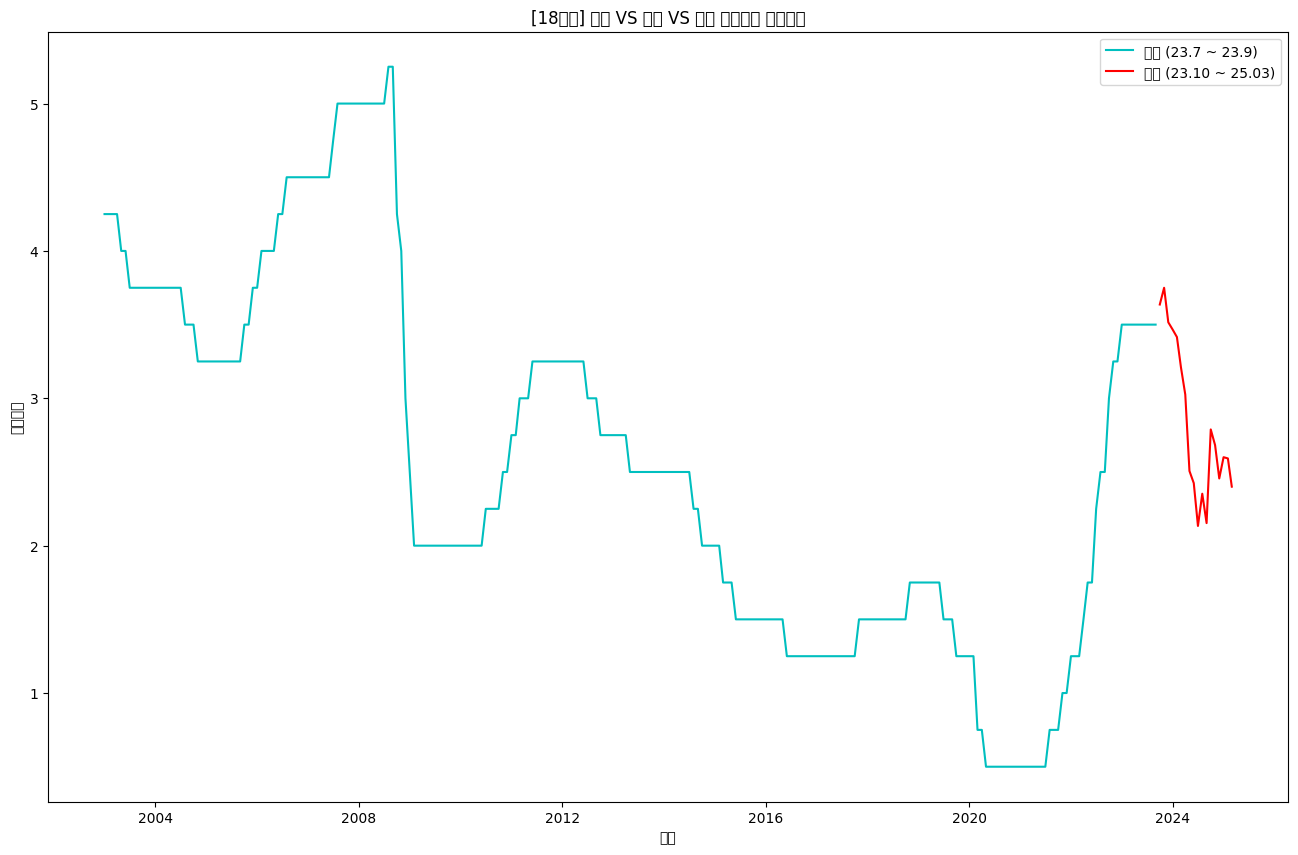

In [85]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_18['날짜'], for_plot_18['0.1'], label='예측 (23.10 ~ 25.03)', c = 'r')

plt.title('[18개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 18개월 검증결과
- 향후 18개월간

### 24개월 단위 예측

- train test split

In [86]:
train = eco_df_for_ts.iloc[: 225, :]
test = eco_df_for_ts.iloc[225 :, :]

train.shape, test.shape

((225, 8), (24, 8))

In [87]:
data = TimeSeriesDataFrame(train)
data

콜금리  CP유통수익률(%p)     미국채_2     미국채_5  \
item_id timestamp                                               
0       2003-01-01  0.803383     0.590164  0.325188  0.580284   
        2003-02-01  0.807611     0.606557  0.302130  0.548103   
        2003-03-01  0.794926     0.622951  0.291327  0.524339   
        2003-04-01  0.794926     0.655738  0.301029  0.554493   
        2003-05-01  0.758985     0.672131  0.259655  0.468492   
...                      ...          ...       ...       ...   
        2021-05-01  0.000000     0.000000  0.007937  0.115159   
        2021-06-01  0.006342     0.000000  0.017470  0.119145   
        2021-07-01  0.010571     0.000000  0.020825  0.103658   
        2021-08-01  0.016913     0.000000  0.020375  0.105321   
        2021-09-01  0.061311     0.000000  0.025105  0.124389   

                    내수출하지수(2020=100)  기준금리  
item_id timestamp                           
0       2003-01-01         -1.743769  4.25  
        2003-02-01         -1.823966  4.25  
        2003-03-01         -1.884114  4.25  
        2003-04-01         -1.974336  4.25  
        2003-05-01         -2.014435  4.00  
...                              ...   ...  
        2021-05-01          0.952867  0.50  
        2021-06-01          0.932818  0.50  
        2021-07-01          0.902744  0.50  
        2021-08-01          0.872670  0.75  
        2021-09-01          0.792472  0.75  

[225 rows x 6 columns]

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [88]:
predictor = TimeSeriesPredictor(
    prediction_length = 24,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070906'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.62 GB / 12.68 GB (83.8%)
Disk Space Avail:   191.64 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 225 rows, 1 time series. Median time series length is 225 (min=225, max=225). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [89]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [90]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [91]:
# 원래값
test['기준금리']

225    0.75
226    1.00
227    1.00
228    1.25
229    1.25
230    1.25
231    1.50
232    1.75
233    1.75
234    2.25
235    2.50
236    2.50
237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [92]:
# 예측값
valid_24 = pred.reset_index()['mean']

pred.reset_index()['mean']

0     0.886830
1     0.867613
2     0.867557
3     0.903122
4     0.903924
5     0.918208
6     0.919599
7     0.908245
8     0.902068
9     0.889409
10    0.888826
11    0.892646
12    0.917738
13    0.938271
14    0.938215
15    0.979374
16    0.979411
17    0.978886
18    0.980328
19    0.969708
20    0.951631
21    0.938967
22    0.939416
23    0.979082
Name: mean, dtype: float64

In [93]:
pred

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2021-10-01  0.886830  0.522340  0.626331  0.727501  0.799122   
        2021-11-01  0.867613  0.390912  0.533421  0.662384  0.757442   
        2021-12-01  0.867557  0.304412  0.476510  0.626517  0.740118   
        2022-01-01  0.903122  0.268427  0.464189  0.632600  0.760642   
        2022-02-01  0.903924  0.205413  0.423424  0.607429  0.749196   
        2022-03-01  0.918208  0.162174  0.400054  0.598409  0.752522   
        2022-04-01  0.919599  0.110351  0.366715  0.577494  0.743847   
        2022-05-01  0.908245  0.049323  0.323036  0.546805  0.723819   
        2022-06-01  0.902068 -0.003653  0.286337  0.521332  0.707150   
        2022-07-01  0.889409 -0.060093  0.244868  0.490561  0.686487   
        2022-08-01  0.888826 -0.103027  0.216565  0.472744  0.676817   
        2022-09-01  0.892646 -0.138909  0.193620  0.460441  0.672550   
        2022-10-01  0.917738 -0.151402  0.194442  0.469478  0.690589   
        2022-11-01  0.938271 -0.168261  0.189467  0.474567  0.703948   
        2022-12-01  0.938215 -0.202833  0.166067  0.460342  0.695897   
        2023-01-01  0.979374 -0.196207  0.185014  0.486093  0.729048   
        2023-02-01  0.979411 -0.229351  0.163547  0.472645  0.722136   
        2023-03-01  0.978886 -0.262687  0.141632  0.459380  0.715728   
        2023-04-01  0.980328 -0.293148  0.122268  0.448340  0.710962   
        2023-05-01  0.969708 -0.334030  0.091549  0.425714  0.694562   
        2023-06-01  0.951631 -0.381917  0.053588  0.393092  0.671359   
        2023-07-01  0.938967 -0.423043  0.022307  0.367874  0.651724   
        2023-08-01  0.939416 -0.450256  0.004384  0.357968  0.646049   
        2023-09-01  0.979082 -0.439341  0.025322  0.386955  0.680076   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2021-10-01  0.886993  0.974928  1.046295  1.147584  1.268027  
        2021-11-01  0.867334  0.977082  1.072281  1.201511  1.360325  
        2021-12-01  0.866955  0.994176  1.107358  1.257756  1.445816  
        2022-01-01  0.901427  1.043015  1.171995  1.339913  1.552332  
        2022-02-01  0.902838  1.056757  1.199099  1.382631  1.618027  
        2022-03-01  0.918313  1.083149  1.237079  1.434870  1.690207  
        2022-04-01  0.919389  1.095449  1.260054  1.471408  1.744576  
        2022-05-01  0.908476  1.092863  1.268546  1.492225  1.782775  
        2022-06-01  0.902607  1.096954  1.281864  1.516493  1.823192  
        2022-07-01  0.889503  1.092740  1.286650  1.532326  1.853595  
        2022-08-01  0.889047  1.100750  1.303810  1.559498  1.893759  
        2022-09-01  0.891833  1.111517  1.324265  1.590258  1.937611  
        2022-10-01  0.916906  1.143398  1.364351  1.639957  2.001584  
        2022-11-01  0.938009  1.171608  1.398607  1.684496  2.057615  
        2022-12-01  0.937318  1.178125  1.413662  1.707227  2.093134  
        2023-01-01  0.978154  1.226688  1.469429  1.770673  2.168396  
        2023-02-01  0.977672  1.232458  1.483196  1.792466  2.202016  
        2023-03-01  0.977799  1.239350  1.494790  1.813634  2.234428  
        2023-04-01  0.979570  1.247049  1.509202  1.835994  2.267092  
        2023-05-01  0.967934  1.241671  1.512287  1.844221  2.286468  
        2023-06-01  0.949521  1.229514  1.505419  1.845644  2.299562  
        2023-07-01  0.937109  1.223605  1.504975  1.852247  2.315557  
        2023-08-01  0.936943  1.228534  1.517310  1.872598  2.344434  
        2023-09-01  0.976697  1.273573  1.568685  1.929547  2.412698

In [94]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[225:, 1] = pred.reset_index()['0.9']
for_plot_pred = for_plot_pred.iloc[225: , :]

<ipython-input-95-cb6f687c7cb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/cor

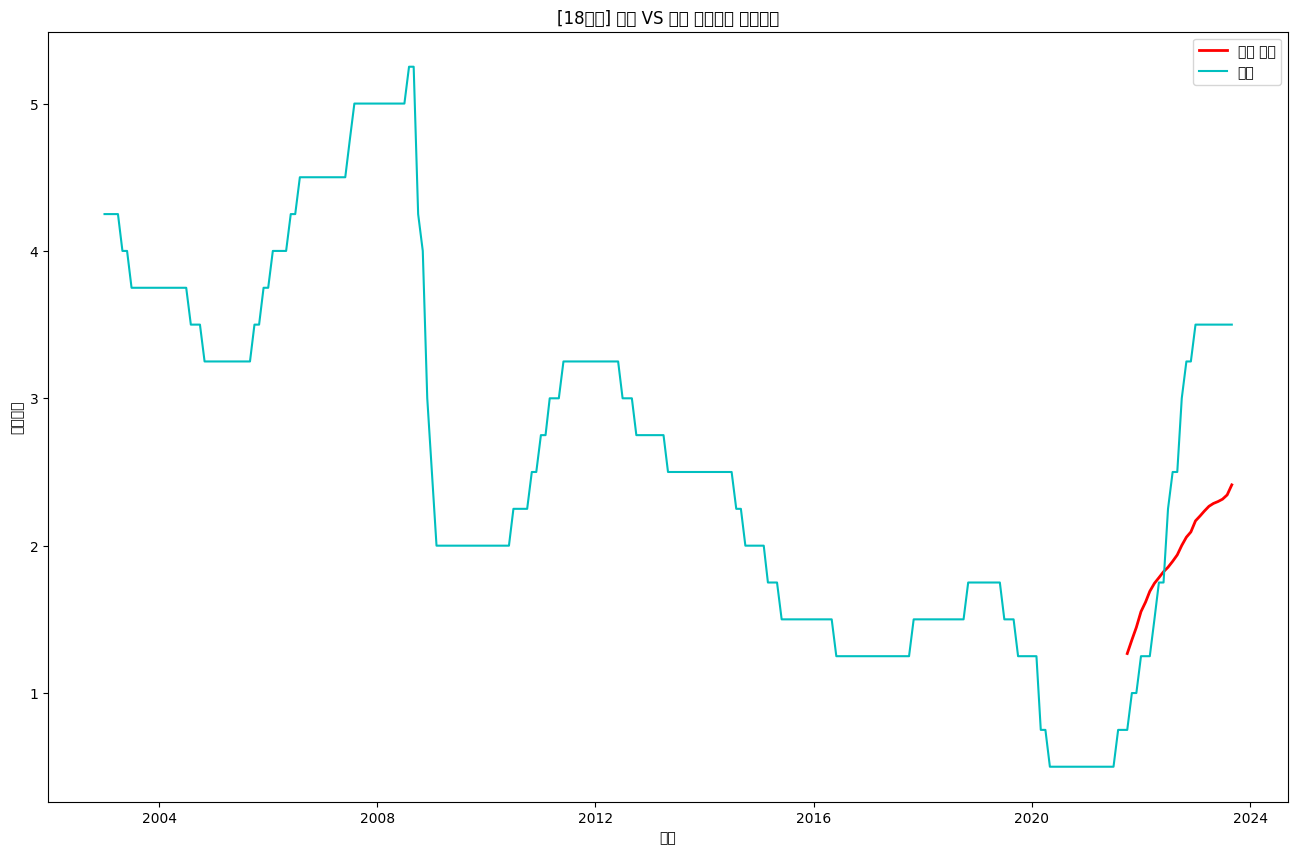

In [95]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[18개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [96]:
predictor = TimeSeriesPredictor(
    prediction_length = 24,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_070918'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.63 GB / 12.68 GB (83.8%)
Disk Space Avail:   191.64 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [97]:
pred_24 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [98]:
pred_24

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  3.913894  3.308442  3.493991  3.601777  3.643614   
        2023-11-01  4.003806  3.431714  3.586566  3.714633  3.773799   
        2023-12-01  3.789375  3.157942  3.334377  3.478006  3.550469   
        2024-01-01  3.857581  3.182558  3.318364  3.475112  3.617609   
        2024-02-01  3.882925  3.145912  3.297747  3.466054  3.677251   
        2024-03-01  3.834191  2.957316  3.241289  3.420046  3.581348   
        2024-04-01  3.754591  2.933599  3.172076  3.301619  3.471132   
        2024-05-01  3.512309  2.531065  2.899593  3.096904  3.274060   
        2024-06-01  3.492203  2.604080  2.866611  3.072322  3.256656   
        2024-07-01  3.264637  2.382650  2.597377  2.811034  3.060980   
        2024-08-01  3.406725  2.355384  2.757062  2.919453  3.175856   
        2024-09-01  3.286577  2.239005  2.591874  2.820309  2.965235   
        2024-10-01  3.890468  2.816681  3.179155  3.414515  3.565360   
        2024-11-01  3.977870  2.998338  3.252406  3.494431  3.709793   
        2024-12-01  3.801881  2.739312  3.061121  3.309576  3.530432   
        2025-01-01  3.961952  2.911318  3.182928  3.437602  3.663772   
        2025-02-01  3.983338  2.903058  3.183028  3.443729  3.675050   
        2025-03-01  3.901785  2.680214  3.085947  3.352501  3.588823   
        2025-04-01  3.780537  2.511264  2.983715  3.255961  3.438323   
        2025-05-01  3.628071  2.317575  2.856539  3.075506  3.321429   
        2025-06-01  3.466874  2.145121  2.632760  2.915958  3.166501   
        2025-07-01  3.203730  1.832999  2.386784  2.616439  2.812670   
        2025-08-01  3.399972  2.167212  2.551685  2.786501  3.104790   
        2025-09-01  3.245695  1.880767  2.389891  2.629758  2.834715   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  3.918012  4.074763  4.175423  4.283209  4.527582  
        2023-11-01  3.946748  4.119696  4.355332  4.424576  4.638252  
        2023-12-01  3.735846  3.921223  4.111333  4.254962  4.490220  
        2024-01-01  3.872287  4.009318  4.210639  4.367387  4.679663  
        2024-02-01  3.941160  4.146246  4.239795  4.408102  4.677584  
        2024-03-01  3.735956  4.008211  4.228336  4.407093  4.808714  
        2024-04-01  3.633414  3.913343  4.141680  4.330046  4.744994  
        2024-05-01  3.384662  3.671734  3.966537  4.163848  4.591199  
        2024-06-01  3.491614  3.608926  3.910906  4.175441  4.496796  
        2024-07-01  3.243461  3.425941  3.675887  3.948368  4.221918  
        2024-08-01  3.423196  3.552888  3.868116  4.089330  4.314537  
        2024-09-01  3.277165  3.471448  3.734022  4.021280  4.315325  
        2024-10-01  3.823997  4.023811  4.351126  4.645310  5.066607  
        2024-11-01  3.914929  4.178889  4.394251  4.695099  5.007991  
        2024-12-01  3.740704  4.009799  4.289479  4.537934  4.800919  
        2025-01-01  3.879011  4.153073  4.379243  4.751564  5.199645  
        2025-02-01  3.895102  4.232802  4.522946  4.783647  5.181264  
        2025-03-01  3.813550  4.097100  4.451068  4.717623  5.182179  
        2025-04-01  3.667596  3.896869  4.255701  4.645595  5.176869  
        2025-05-01  3.496307  3.847655  4.211225  4.430192  4.910332  
        2025-06-01  3.404521  3.701364  4.069554  4.352752  4.781568  
        2025-07-01  3.172554  3.414790  3.728669  4.075971  4.570933  
        2025-08-01  3.409972  3.715154  3.974619  4.268259  4.652732  
        2025-09-01  3.261577  3.453146  3.834574  4.133264  4.701211

In [99]:
for_plot_24 = pred_24.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

<ipython-input-100-2cee80b36849>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/co

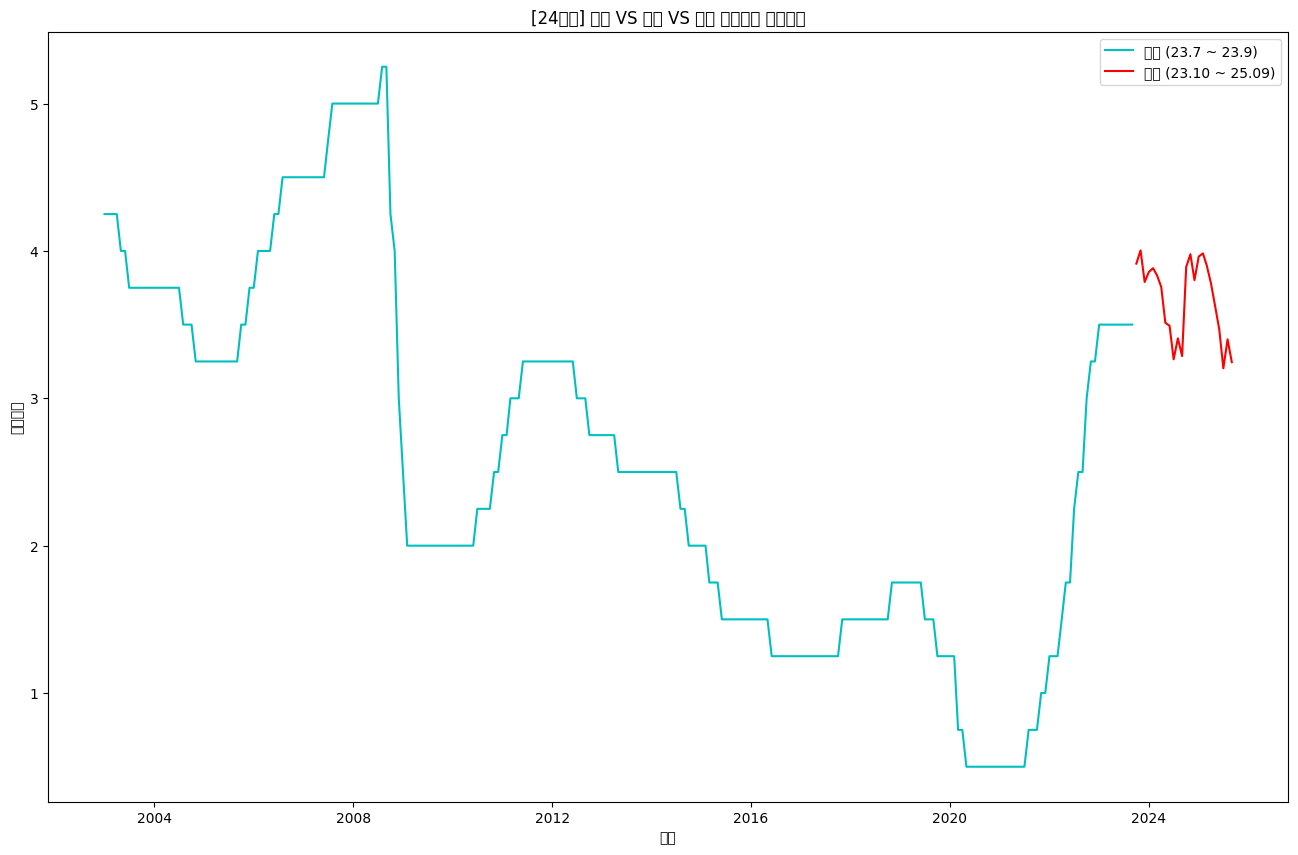

In [100]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_24['날짜'] = pd.to_datetime(for_plot_24['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_24['날짜'], for_plot_24['mean'], label='예측 (23.10 ~ 25.09)', c = 'r')

plt.title('[24개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 18개월 검증결과
- 향후 18개월간

### 30개월 단위 예측

- train test split

In [101]:
train = eco_df_for_ts.iloc[: 219, :]
test = eco_df_for_ts.iloc[219 :, :]

train.shape, test.shape

((219, 8), (30, 8))

In [102]:
data = TimeSeriesDataFrame(train)
data

콜금리  CP유통수익률(%p)     미국채_2     미국채_5  \
item_id timestamp                                               
0       2003-01-01  0.803383     0.590164  0.325188  0.580284   
        2003-02-01  0.807611     0.606557  0.302130  0.548103   
        2003-03-01  0.794926     0.622951  0.291327  0.524339   
        2003-04-01  0.794926     0.655738  0.301029  0.554493   
        2003-05-01  0.758985     0.672131  0.259655  0.468492   
...                      ...          ...       ...       ...   
        2020-11-01  0.002114     0.016393  0.010092  0.025253   
        2020-12-01  0.006342     0.016393  0.004124  0.024839   
        2021-01-01  0.002114     0.016393  0.003154  0.037203   
        2021-02-01  0.002114     0.000000  0.000000  0.057485   
        2021-03-01  0.002114     0.000000  0.006330  0.115897   

                    내수출하지수(2020=100)  기준금리  
item_id timestamp                           
0       2003-01-01         -1.743769  4.25  
        2003-02-01         -1.823966  4.25  
        2003-03-01         -1.884114  4.25  
        2003-04-01         -1.974336  4.25  
        2003-05-01         -2.014435  4.00  
...                              ...   ...  
        2020-11-01          1.083188  0.50  
        2020-12-01          1.083188  0.50  
        2021-01-01          1.013015  0.50  
        2021-02-01          1.023040  0.50  
        2021-03-01          0.992966  0.50  

[219 rows x 6 columns]

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [103]:
predictor = TimeSeriesPredictor(
    prediction_length = 30,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_071013'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.58 GB / 12.68 GB (83.4%)
Disk Space Avail:   191.63 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 219 rows, 1 time series. Median time series length is 219 (min=219, max=219). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [104]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [105]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


done


In [106]:
# 원래값
test['기준금리']

219    0.50
220    0.50
221    0.50
222    0.50
223    0.75
224    0.75
225    0.75
226    1.00
227    1.00
228    1.25
229    1.25
230    1.25
231    1.50
232    1.75
233    1.75
234    2.25
235    2.50
236    2.50
237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [107]:
# 예측값
valid_30 = pred.reset_index()['0.9']

pred.reset_index()['0.9']

0     1.253349
1     1.212416
2     1.293959
3     1.352652
4     1.368061
5     1.386843
6     1.403460
7     1.421387
8     1.434777
9     1.468889
10    1.473581
11    1.481893
12    1.435076
13    1.374078
14    1.441681
15    1.490040
16    1.495602
17    1.506510
18    1.512395
19    1.522211
20    1.530457
21    1.557929
22    1.558930
23    1.546934
24    1.480921
25    1.412067
26    1.476121
27    1.524046
28    1.529481
29    1.539773
Name: 0.9, dtype: float64

In [108]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[219:, 1] = pred.reset_index()['0.9']
for_plot_pred = for_plot_pred.iloc[219: , :]

<ipython-input-109-00444e7a3544>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/co

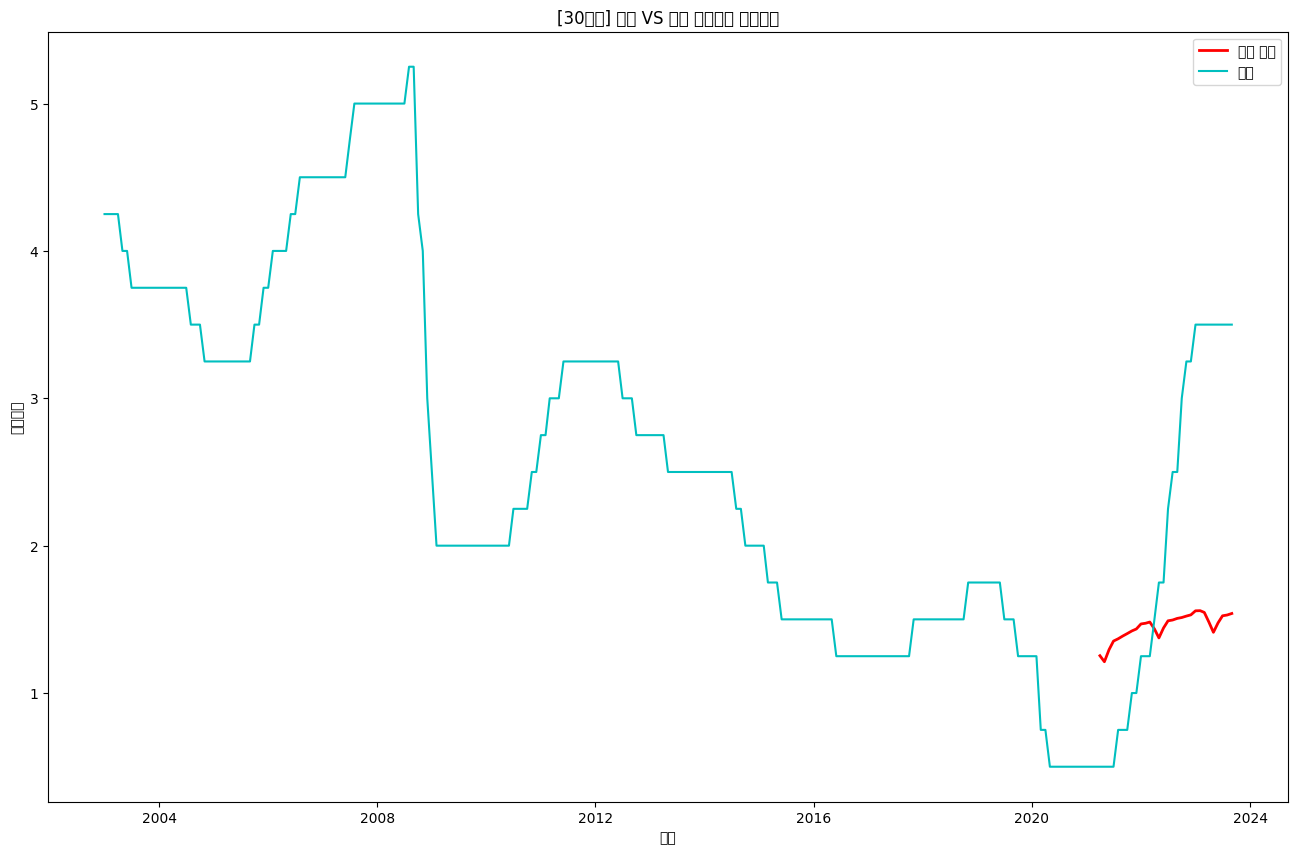

In [109]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[30개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [110]:
predictor = TimeSeriesPredictor(
    prediction_length = 30,
    target="기준금리",
    eval_metric="RMSE"
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_071026'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.57 GB / 12.68 GB (83.4%)
Disk Space Avail:   191.63 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [111]:
pred_30 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [112]:
pred_30

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  4.309142  4.037898  4.126854  4.186192  4.227607   
        2023-11-01  4.509233  4.177859  4.283789  4.363203  4.421772   
        2023-12-01  4.317936  3.925306  4.052599  4.147419  4.219151   
        2024-01-01  4.350035  3.906568  4.041003  4.148809  4.242508   
        2024-02-01  4.371014  3.879041  4.029343  4.148592  4.262936   
        2024-03-01  4.297977  3.745626  3.932014  4.061606  4.173920   
        2024-04-01  4.174803  3.601849  3.790559  3.918794  4.039236   
        2024-05-01  3.880343  3.248792  3.471520  3.619480  3.747487   
        2024-06-01  3.731662  3.089777  3.302299  3.458574  3.593687   
        2024-07-01  3.473136  2.806106  3.018665  3.182806  3.335509   
        2024-08-01  3.817493  3.094806  3.350350  3.511101  3.670197   
        2024-09-01  3.696962  2.951811  3.206398  3.385167  3.528631   
        2024-10-01  4.508569  3.735177  3.999272  4.184897  4.334219   
        2024-11-01  4.695004  3.917243  4.168747  4.360969  4.526798   
        2024-12-01  4.497462  3.683987  3.955188  4.153775  4.325042   
        2025-01-01  4.735763  3.904373  4.173242  4.377986  4.554513   
        2025-02-01  4.805084  3.947849  4.224994  4.435704  4.617330   
        2025-03-01  4.716198  3.815231  4.122150  4.338653  4.525230   
        2025-04-01  4.598433  3.668180  3.993783  4.215921  4.396443   
        2025-05-01  4.339763  3.384837  3.728920  3.945678  4.141759   
        2025-06-01  3.950195  2.977449  3.318086  3.551066  3.751721   
        2025-07-01  3.439581  2.439414  2.798170  3.025507  3.241497   
        2025-08-01  3.594959  2.601759  2.934992  3.167439  3.387795   
        2025-09-01  3.133502  2.101626  2.463532  2.700978  2.903866   
        2025-10-01  3.571987  2.551744  2.887831  3.141043  3.348115   
        2025-11-01  3.502062  2.442321  2.795934  3.043075  3.275988   
        2025-12-01  3.166247  2.094335  2.454476  2.706326  2.943261   
        2026-01-01  3.382222  2.292183  2.647864  2.915204  3.156088   
        2026-02-01  3.359638  2.258107  2.620083  2.891963  3.125857   
        2026-03-01  3.257869  2.108420  2.509194  2.774666  3.023242   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  4.309794  4.370242  4.422526  4.481864  4.581690  
        2023-11-01  4.498254  4.574736  4.665914  4.734459  4.851258  
        2023-12-01  4.307936  4.396721  4.490193  4.585012  4.723175  
        2024-01-01  4.352535  4.440823  4.545391  4.653197  4.820241  
        2024-02-01  4.382101  4.468658  4.583002  4.702251  4.874293  
        2024-03-01  4.279607  4.407034  4.530217  4.659810  4.867936  
        2024-04-01  4.152521  4.287544  4.418856  4.568830  4.768410  
        2024-05-01  3.856973  3.999068  4.148814  4.296773  4.508632  
        2024-06-01  3.731553  3.847681  4.004533  4.171677  4.395069  
        2024-07-01  3.468788  3.602066  3.754770  3.929779  4.153209  
        2024-08-01  3.820320  3.948703  4.118668  4.290290  4.513224  
        2024-09-01  3.695332  3.840294  4.005497  4.195136  4.438853  
        2024-10-01  4.495526  4.656833  4.827894  5.024389  5.299353  
        2024-11-01  4.682504  4.849079  5.036647  5.217999  5.480373  
        2024-12-01  4.485832  4.657491  4.839627  5.038215  5.298546  
        2025-01-01  4.720220  4.896795  5.073323  5.299805  5.601283  
        2025-02-01  4.787801  4.980012  5.172507  5.383217  5.682101  
        2025-03-01  4.700328  4.886296  5.094612  5.311116  5.628904  
        2025-04-01  4.576042  4.755641  4.979641  5.212649  5.549121  
        2025-05-01  4.314871  4.520592  4.738412  4.966039  5.288384  
        2025-06-01  3.939978  4.117365  4.361498  4.594478  4.924246  
        2025-07-01  3.433929  3.626360  3.842351  4.091427  4.439313  
        2025-08

In [113]:
for_plot_30 = pred_30.reset_index()[['timestamp','0.1']].rename(columns = {'timestamp' : '날짜'})

<ipython-input-114-613bf9c828f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/co

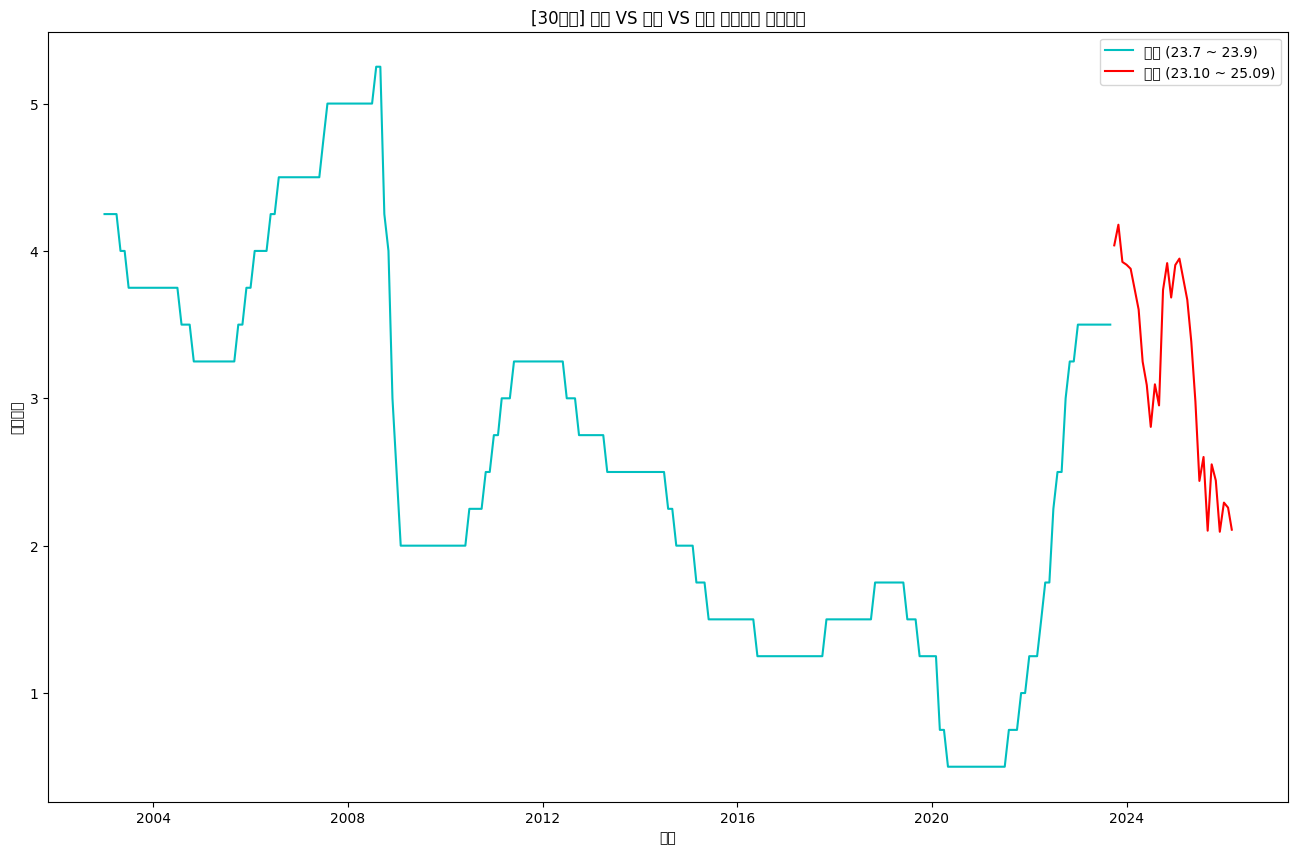

In [114]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_30['날짜'] = pd.to_datetime(for_plot_30['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_30['날짜'], for_plot_30['0.1'], label='예측 (23.10 ~ 25.09)', c = 'r')

plt.title('[30개월] 실제 VS 검증 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 18개월 검증결과
- 향후 18개월간

### 36개월 단위 예측

- train test split

In [115]:
train = eco_df_for_ts.iloc[: 213, :]
test = eco_df_for_ts.iloc[213 :, :]

train.shape, test.shape

((213, 8), (36, 8))

In [116]:
data = TimeSeriesDataFrame(train)
data

콜금리  CP유통수익률(%p)     미국채_2     미국채_5  \
item_id timestamp                                               
0       2003-01-01  0.803383     0.590164  0.325188  0.580284   
        2003-02-01  0.807611     0.606557  0.302130  0.548103   
        2003-03-01  0.794926     0.622951  0.291327  0.524339   
        2003-04-01  0.794926     0.655738  0.301029  0.554493   
        2003-05-01  0.758985     0.672131  0.259655  0.468492   
...                      ...          ...       ...       ...   
        2020-05-01  0.046512     0.147541  0.011033  0.015172   
        2020-06-01  0.000000     0.147541  0.013929  0.016223   
        2020-07-01  0.000000     0.114754  0.006575  0.002493   
        2020-08-01  0.004228     0.081967  0.004846  0.000000   
        2020-09-01  0.000000     0.065574  0.003895  0.000595   

                    내수출하지수(2020=100)  기준금리  
item_id timestamp                           
0       2003-01-01         -1.743769  4.25  
        2003-02-01         -1.823966  4.25  
        2003-03-01         -1.884114  4.25  
        2003-04-01         -1.974336  4.25  
        2003-05-01         -2.014435  4.00  
...                              ...   ...  
        2020-05-01          0.451633  0.50  
        2020-06-01          0.401510  0.50  
        2020-07-01          0.401510  0.50  
        2020-08-01          0.642102  0.50  
        2020-09-01          0.812522  0.50  

[213 rows x 6 columns]

#### validation

- AutoGluon 자동화 시계열 예측 모델 학습

In [117]:
predictor = TimeSeriesPredictor(
    prediction_length = 36,
    target="기준금리",
    eval_metric="RMSE"
)

# seed 고정
predictor.fit( data, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_071107'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.53 GB / 12.68 GB (83.1%)
Disk Space Avail:   191.62 GB / 225.83 GB (84.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 36,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 213 rows, 1 time series. Median time series length is 213 (min=213, max=213). 

Provided da

- 전체 데이터를 대상으로 다시 학습

In [118]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: CrostonSBA_FULL | Skipping fit via cloning parent ...
Fitting model: NPTS_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: DynamicOptimizedTheta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoARIMA_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL | Skipping fit via cloning parent ...
Fitting model: DirectTabular_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['SeasonalNaive_FULL', 'CrostonSBA_FULL', 'NPTS_FUL

{'SeasonalNaive': 'SeasonalNaive_FULL',
 'CrostonSBA': 'CrostonSBA_FULL',
 'NPTS': 'NPTS_FULL',
 'AutoETS': 'AutoETS_FULL',
 'DynamicOptimizedTheta': 'DynamicOptimizedTheta_FULL',
 'AutoARIMA': 'AutoARIMA_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DirectTabular': 'DirectTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

- validation set 예측

In [119]:
# 예측
pred = predictor.predict(data, random_seed=42, )

print('done')

Model not specified in predict, will default to the model with the best validation score: AutoARIMA_FULL


done


In [120]:
# 원래값
test['기준금리']

213    0.50
214    0.50
215    0.50
216    0.50
217    0.50
218    0.50
219    0.50
220    0.50
221    0.50
222    0.50
223    0.75
224    0.75
225    0.75
226    1.00
227    1.00
228    1.25
229    1.25
230    1.25
231    1.50
232    1.75
233    1.75
234    2.25
235    2.50
236    2.50
237    3.00
238    3.25
239    3.25
240    3.50
241    3.50
242    3.50
243    3.50
244    3.50
245    3.50
246    3.50
247    3.50
248    3.50
Name: 기준금리, dtype: float64

In [121]:
# 예측값
valid_36 = pred.reset_index()['0.9']

pred.reset_index()

,item_id,timestamp,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,2020-10-01,0.501699,0.331177,0.389714,0.431923,0.467989,0.501699,0.535409,0.571475,0.613684,0.672221
1,0,2020-11-01,0.494837,0.239278,0.327006,0.390264,0.444316,0.494837,0.545357,0.599409,0.662667,0.750395
2,0,2020-12-01,0.491653,0.125414,0.251136,0.341791,0.419252,0.491653,0.564054,0.641515,0.732170,0.857892
3,0,2021-01-01,0.490176,0.019444,0.181037,0.297556,0.397118,0.490176,0.583234,0.682796,0.799316,0.960908
4,0,2021-02-01,0.489491,-0.074821,0.118895,0.258579,0.377933,0.489491,0.601049,0.720403,0.860087,1.053804
5,0,2021-03-01,0.489173,-0.158772,0.063654,0.224039,0.361082,0.489173,0.617264,0.754307,0.914693,1.137119
6,0,2021-04-01,0.489026,-0.234405,0.013934,0.193004,0.346012,0.489026,0.632039,0.785048,0.964118,1.212457
7,0,2021-05-01,0.488958,-0.303424,-0.031416,0.164721,0.332313,0.488958,0.645602,0.813194,1.009331,1.281339
8,0,2021-06-01,0.488926,-0.367140,-0.073270,0.138630,0.319692,0.488926,0.658160,0.839221,1.051122,1.344992
9,0,2021-07-01,0.488911,-0.426537,-0.112283,0.114317,0.307938,0.488911,0.669884,0.863505,1.090105,1.404360


In [122]:
for_plot = eco_df[['날짜', '기준금리']]
for_plot_pred = for_plot.copy()
for_plot_pred.iloc[213:, 1] = pred.reset_index()['0.9']
for_plot_pred = for_plot_pred.iloc[213: , :]

<ipython-input-123-b81c2ff55f17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/co

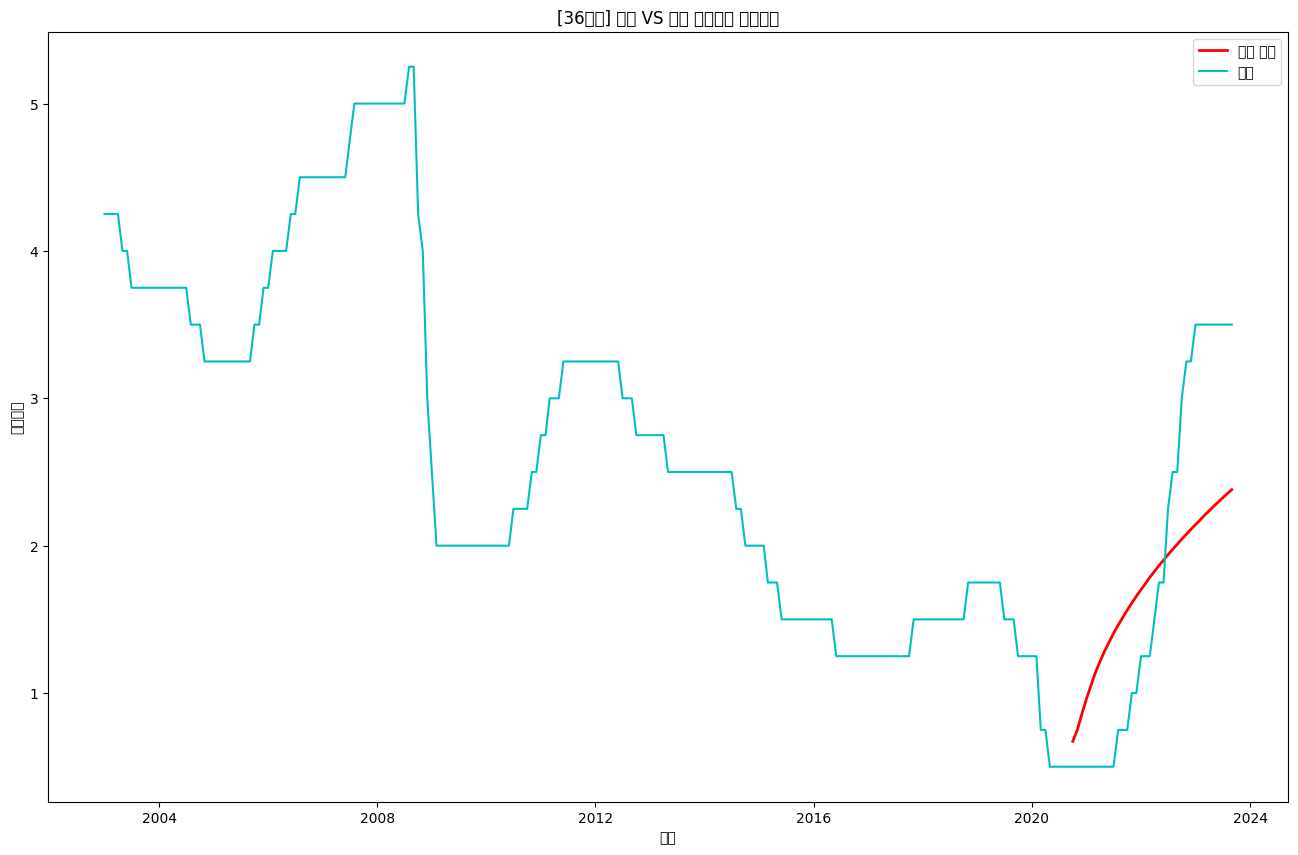

In [123]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_pred['날짜'] = pd.to_datetime(for_plot_pred['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot_pred['날짜'], for_plot_pred['기준금리'], label='예측 결과', c = 'r',  linewidth=2)
plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제', c = 'c')

plt.title('[36개월] 실제 VS 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

#### Prediction

In [124]:
predictor = TimeSeriesPredictor(
    prediction_length = 36,
    target="기준금리",
    eval_metric="RMSE",
)

# seed 고정
predictor.fit( eco_df_for_ts, random_seed=42, presets="best_quality")

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20231207_071118'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       10.54 GB / 12.68 GB (83.2%)
Disk Space Avail:   191.62 GB / 225.83 GB (84.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 36,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '기준금리',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 249 rows, 1 time series. Median time series length is 249 (min=249, max=249). 

Provided da

In [125]:
pred_36 = predictor.predict(eco_df_for_ts, random_seed=42, )

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [126]:
pred_36

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
0       2023-10-01  2.638832  0.655867  1.700964  2.109833  2.382361   
        2023-11-01  2.645947  0.513503  1.609913  2.055782  2.359926   
        2023-12-01  2.646013  0.398870  1.534653  2.008914  2.337317   
        2024-01-01  2.740649  0.396811  1.565788  2.063983  2.412838   
        2024-02-01  2.713926  0.284898  1.483119  2.002402  2.369274   
        2024-03-01  2.717114  0.211069  1.435728  1.974075  2.357237   
        2024-04-01  2.726136  0.149264  1.398237  1.954115  2.352257   
        2024-05-01  2.714118  0.071325  1.342927  1.915122  2.327207   
        2024-06-01  2.773730  0.069020  1.361877  1.949398  2.374579   
        2024-07-01  2.688313 -0.074958  1.238001  1.840019  2.277585   
        2024-08-01  2.726258 -0.092713  1.239367  1.855172  2.304519   
        2024-09-01  2.710417 -0.161775  1.188575  1.817553  2.278157   
        2024-10-01  2.763540 -0.159696  1.208176  1.849789  2.321189   
        2024-11-01  2.858811 -0.113542  1.271191  1.924962  2.406750   
        2024-12-01  2.887363 -0.132382  1.268620  1.934122  2.425933   
        2025-01-01  2.895633 -0.169949  1.246788  1.923636  2.425142   
        2025-02-01  2.895760 -0.214248  1.217739  1.905584  2.416486   
        2025-03-01  2.905177 -0.247968  1.198828  1.897350  2.417376   
        2025-04-01  2.895430 -0.299669  1.161528  1.870435  2.399335   
        2025-05-01  2.874808 -0.361155  1.114070  1.833092  2.370635   
        2025-06-01  2.855690 -0.420128  1.068778  1.797665  2.343637   
        2025-07-01  2.690496 -0.624238  0.878028  1.616548  2.170751   
        2025-08-01  2.763737 -0.589038  0.926286  1.674222  2.236471   
        2025-09-01  2.589193 -0.800806  0.727296  1.484446  2.054568   
        2025-10-01  2.660958 -0.765497  0.775120  1.541294  2.119126   
        2025-11-01  2.857016 -0.605172  0.947711  1.722730  2.308120   
        2025-12-01  2.971933 -0.525307  1.039609  1.823305  2.416109   
        2026-01-01  2.963493 -0.568157  1.008572  1.800785  2.400866   
        2026-02-01  3.073218 -0.492232  1.096099  1.896679  2.503909   
        2026-03-01  3.109375 -0.489297  1.110439  1.919242  2.533499   
        2026-04-01  3.099015 -0.532330  1.078622  1.895512  2.516680   
        2026-05-01  3.180184 -0.483311  1.138677  1.963525  2.591493   
        2026-06-01  3.174195 -0.520951  1.111902  1.944585  2.579247   
        2026-07-01  3.135532 -0.590790  1.052765  1.893165  2.534421   
        2026-08-01  3.122464 -0.634578  1.019522  1.867526  2.515280   
        2026-09-01  3.082817 -0.704510  0.959987  1.815487  2.469645   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
0       2023-10-01  2.638832  2.895303  3.167832  3.576701  4.621797  
        2023-11-01  2.645947  2.931967  3.236111  3.681981  4.778390  
        2023-12-01  2.646012  2.954708  3.283111  3.757371  4.893154  
        2024-01-01  2.740649  3.068460  3.417314  3.915510  5.084486  
        2024-02-01  2.713926  3.058578  3.425451  3.944733  5.142954  
        2024-03-01  2.717114  3.076992  3.460154  3.998501  5.223160  
        2024-04-01  2.726136  3.100015  3.498157  4.054035  5.303007  
        2024-05-01  2.714118  3.101029  3.513114  4.085310  5.356912  
        2024-06-01  2.773730  3.172881  3.598061  4.185583  5.478440  
        2024-07-01  2.688313  3.099041  3.536607  4.138625  5.451584  
        2024-08-01  2.726258  3.147997  3.597344  4.213149  5.545229  
        2024-09-01  2.710417  3.142677  3.603280  4.232258  5.582608  
        2024-10-01  2.763540  3.205891  3.677291  4.318904  5.686777  
        2024-11-01  2.858811  3.310872  3.792660  4.446431  5.831164  
        2024-12-01  2.887363  3.348793  3.840605  4.506107  5.907109  
        2025-01-01  2.895633  3.366124  3.867631  4.544479  5.961215  
        2

In [127]:
for_plot_36 = pred_36.reset_index()[['timestamp','mean']].rename(columns = {'timestamp' : '날짜'})

<ipython-input-128-cc58d0a5e5bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/co

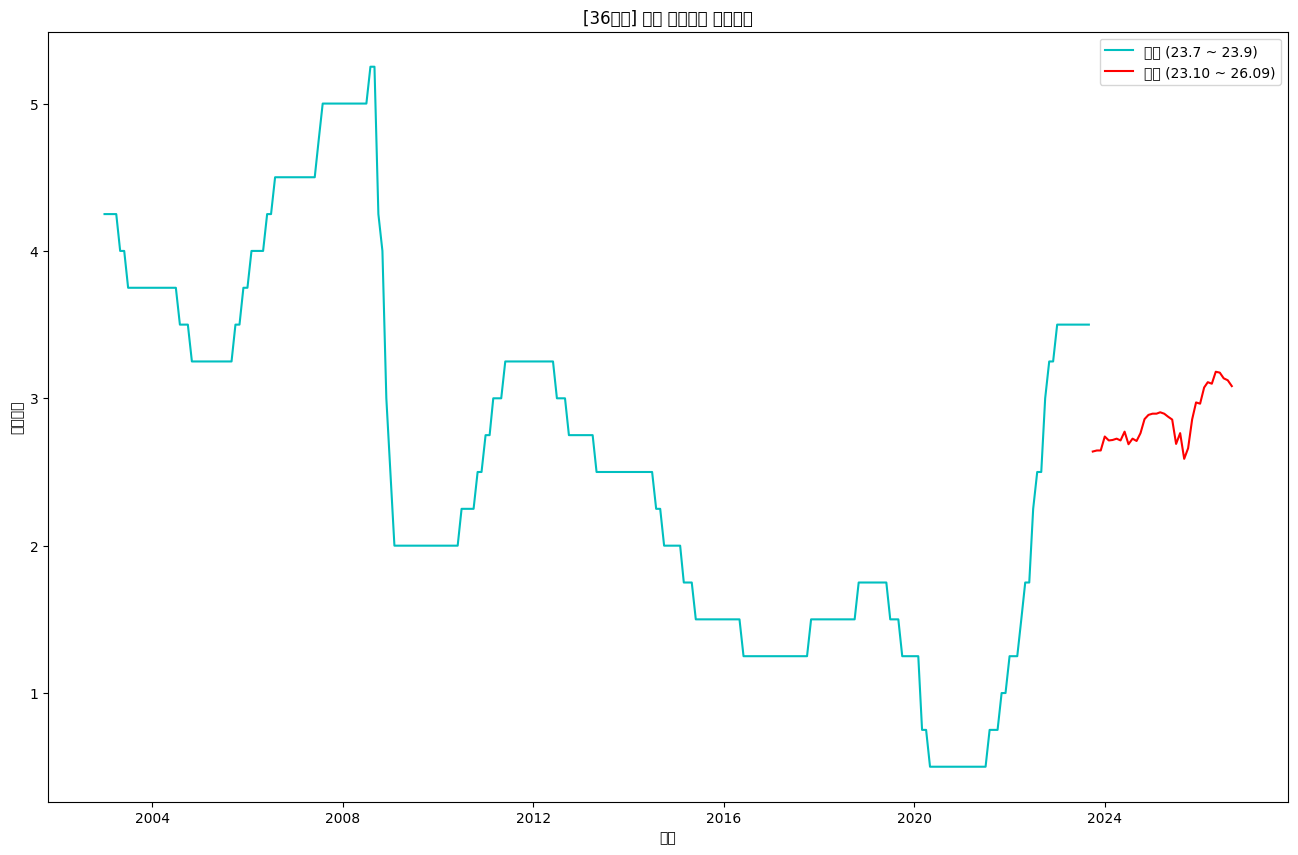

In [128]:
for_plot['날짜'] = pd.to_datetime(for_plot['날짜'])
for_plot_36['날짜'] = pd.to_datetime(for_plot_36['날짜'])

plt.figure(figsize=(16, 10))

plt.plot(for_plot['날짜'], for_plot['기준금리'], label='실제 (23.7 ~ 23.9)', c = 'c')
plt.plot(for_plot_36['날짜'], for_plot_36['mean'], label='예측 (23.10 ~ 26.09)', c = 'r')

plt.title('[36개월] 예측 한국은행 기준금리')

plt.xlabel('날짜')

plt.ylabel('기준금리')

plt.legend()

plt.show()

- 36개월간 예측 결과


In [129]:
a = for_plot_36.merge(for_plot_30, how = 'left', on = '날짜').merge(for_plot_24, how = 'left', on='날짜').rename(columns = {'mean_x' : 'mean_36', '0.1' : 'mean_30', 'mean_y' : 'mean_24'})

In [130]:
b = a.merge(for_plot_18, how = 'left', on = '날짜').merge(for_plot_12, how = 'left', on = '날짜').merge(for_plot_6, how = 'left', on = '날짜').rename(columns = {'0.1' : 'mean_18', 'mean_x' : 'mean_12', 'mean_y' : 'mean_6'})
c = b.merge(for_plot_3, how = 'left', on = '날짜').rename(columns = {'mean':'mean_3'})

In [131]:
c

,날짜,mean_36,mean_30,mean_24,mean_18,mean_12,mean_6,mean_3
0,2023-10-01,2.638832,4.037898,3.913894,3.636395,3.734116,3.512280,3.5
1,2023-11-01,2.645947,4.177859,4.003806,3.750048,3.685753,3.513914,3.5
2,2023-12-01,2.646013,3.925306,3.789375,3.515726,3.509016,3.511042,3.5
3,2024-01-01,2.740649,3.906568,3.857581,3.466936,3.623616,3.515321,NaN
4,2024-02-01,2.713926,3.879041,3.882925,3.415577,3.645766,3.517859,NaN
5,2024-03-01,2.717114,3.745626,3.834191,3.209727,3.590398,3.517821,NaN
6,2024-04-01,2.726136,3.601849,3.754591,3.025279,3.502121,NaN,NaN
7,2024-05-01,2.714118,3.248792,3.512309,2.506714,3.217683,NaN,NaN
8,2024-06-01,2.773730,3.089777,3.492203,2.424277,2.433310,NaN,NaN
9,2024-07-01,2.688313,2.806106,3.264637,2.133853,1.451704,NaN,NaN


In [132]:
c.to_csv('/content/drive/MyDrive/ASAC_최종프로젝트/★ 한석 ★/3.경제지표데이터/autogluon_result.csv', index = False)

- 36개월간 validation 저장

In [133]:
val_result_ag = pd.read_csv('/content/drive/MyDrive/ASAC_최종프로젝트/★ 한석 ★/3.경제지표데이터/validation_result_ag.csv', encoding = 'cp949')

In [134]:
val_result_ag.iloc[-3:, -1] = valid_3
val_result_ag.iloc[-6:, -2] = valid_6
val_result_ag.iloc[-12:, -3] = valid_12
val_result_ag.iloc[-18:, -4] = valid_18
val_result_ag.iloc[-24:, -5] = valid_24
val_result_ag.iloc[-30:, -6] = valid_30
val_result_ag.iloc[-36:, -7] = valid_36

In [135]:
val_result_ag

,Unnamed: 0,날짜,기준금리,mean_36,mean_30,mean_24,mean_18,mean_12,mean_6,mean_3
0,0,2020-10-01,0.50,0.672221,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-11-01,0.50,0.750395,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-12-01,0.50,0.857892,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2021-01-01,0.50,0.960908,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2021-02-01,0.50,1.053804,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2021-03-01,0.50,1.137119,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2021-04-01,0.50,1.212457,1.253349,NaN,NaN,NaN,NaN,NaN
7,7,2021-05-01,0.50,1.281339,1.212416,NaN,NaN,NaN,NaN,NaN
8,8,2021-06-01,0.50,1.344992,1.293959,NaN,NaN,NaN,NaN,NaN
9,9,2021-07-01,0.50,1.404360,1.352652,NaN,NaN,NaN,NaN,NaN


In [136]:
val_result_ag.to_csv('/content/drive/MyDrive/ASAC_최종프로젝트/★ 한석 ★/3.경제지표데이터/validation_result_ag.csv', encoding = 'cp949')